# 🧑‍🏫 Aula 4 - Visão "Clássica" vs Serviço Cognitivo

---

## 📚 Sumário

1. [Introdução: O que é Visão Clássica?](#1-introdução-o-que-é-visão-clássica)
2. [Extração de Atributos Manuais (Handcrafted Features)](#2-extração-de-atributos-manuais-handcrafted-features)
3. [Treinamento de Modelo Local (SVM/Random Forest)](#3-treinamento-de-modelo-local-svmrandom-forest)
4. [Comparação: Clássico vs Azure Custom Vision](#4-comparação-clássico-vs-azure-custom-vision)

---

## 🎯 Capacidades Técnicas Trabalhadas

- **Determinar o atributo a ser utilizado** como elemento para aplicação de metodologia de reconhecimento.
- **Avaliar diferentes métodos** de reconhecimento de padrões (biológicos/clássicos vs artificiais/dl).

## 🤝 Capacidades Socioemocionais Trabalhadas

- **Criatividade e originalidade**: Buscar soluções alternativas quando serviços prontos não são viáveis.

---

## 1. Introdução: O que é Visão Clássica?

Antes do Deep Learning (CNNs), usávamos algoritmos para extrair características matemáticas das imagens:
- Histogramas de cor
- Bordas (Canny, Sobel)
- Texturas (LBP, Haralick)

Hoje vamos tentar classificar os defeitos de impressão 3D usando essa abordagem e comparar com a facilidade do Azure.

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [10, 6]

print("✅ Bibliotecas carregadas!")

✅ Bibliotecas carregadas!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---

## 2. Extração de Atributos Manuais

Vamos criar uma função que recebe uma imagem e retorna um vetor de números (features).
Focaremos em:
1. **Média de Cor (RGB)**: A cor da peça importa?
2. **Histograma**: Distribuição de intensidade.
3. **Bordas**: Quantidade de bordas (peças quebradas podem ter mais bordas irregulares).

In [17]:
def read_image(image_path):
    """Lê imagem suportando caminhos com caracteres especiais (acentos, etc.)"""
    img = cv2.imread(str(image_path))
    if img is None:
        # Fallback para caminhos com caracteres Unicode (ex: "Avaliação")
        data = np.fromfile(str(image_path), dtype=np.uint8)
        img = cv2.imdecode(data, cv2.IMREAD_COLOR)
    return img

def extract_features(image_path):
    img = read_image(image_path)
    if img is None: return None

    # 1. Cor Média (B, G, R)
    mean_color = img.mean(axis=(0,1))

    # 2. Desvio Padrão (Contraste)
    std_color = img.std(axis=(0,1))

    # 3. Detecção de Bordas (Canny)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    edge_density = np.sum(edges) / (edges.shape[0] * edges.shape[1])

    # Concatena tudo num vetor único
    features = np.concatenate([mean_color, std_color, [edge_density]])
    return features

# Teste em uma imagem
DATASET_PATH = Path("Dataset")
# Pega uma imagem qualquer para teste
sample_files = list(DATASET_PATH.glob("*/*.jpg"))
if sample_files:
    feat = extract_features(sample_files[0])
    print("Vetor de Features (Exemplo):", feat)
else:
    print("Dataset não encontrado para teste.")

Vetor de Features (Exemplo): [110.56352865 117.40243164 112.71379232  79.98152184  78.30870609
  78.31106586   3.2671875 ]


### 🔍 Visualização dos Filtros Aplicados

Vamos ver passo a passo o que acontece quando processamos uma imagem:
1. **Imagem Original (BGR)** → como a câmera captura
2. **Canais Separados (B, G, R)** → decomposição em cores
3. **Escala de Cinza** → simplificação para 1 canal
4. **Filtro Canny (Detecção de Bordas)** → destaca contornos

Isso ajuda a entender **o que cada feature realmente "vê"** na imagem.

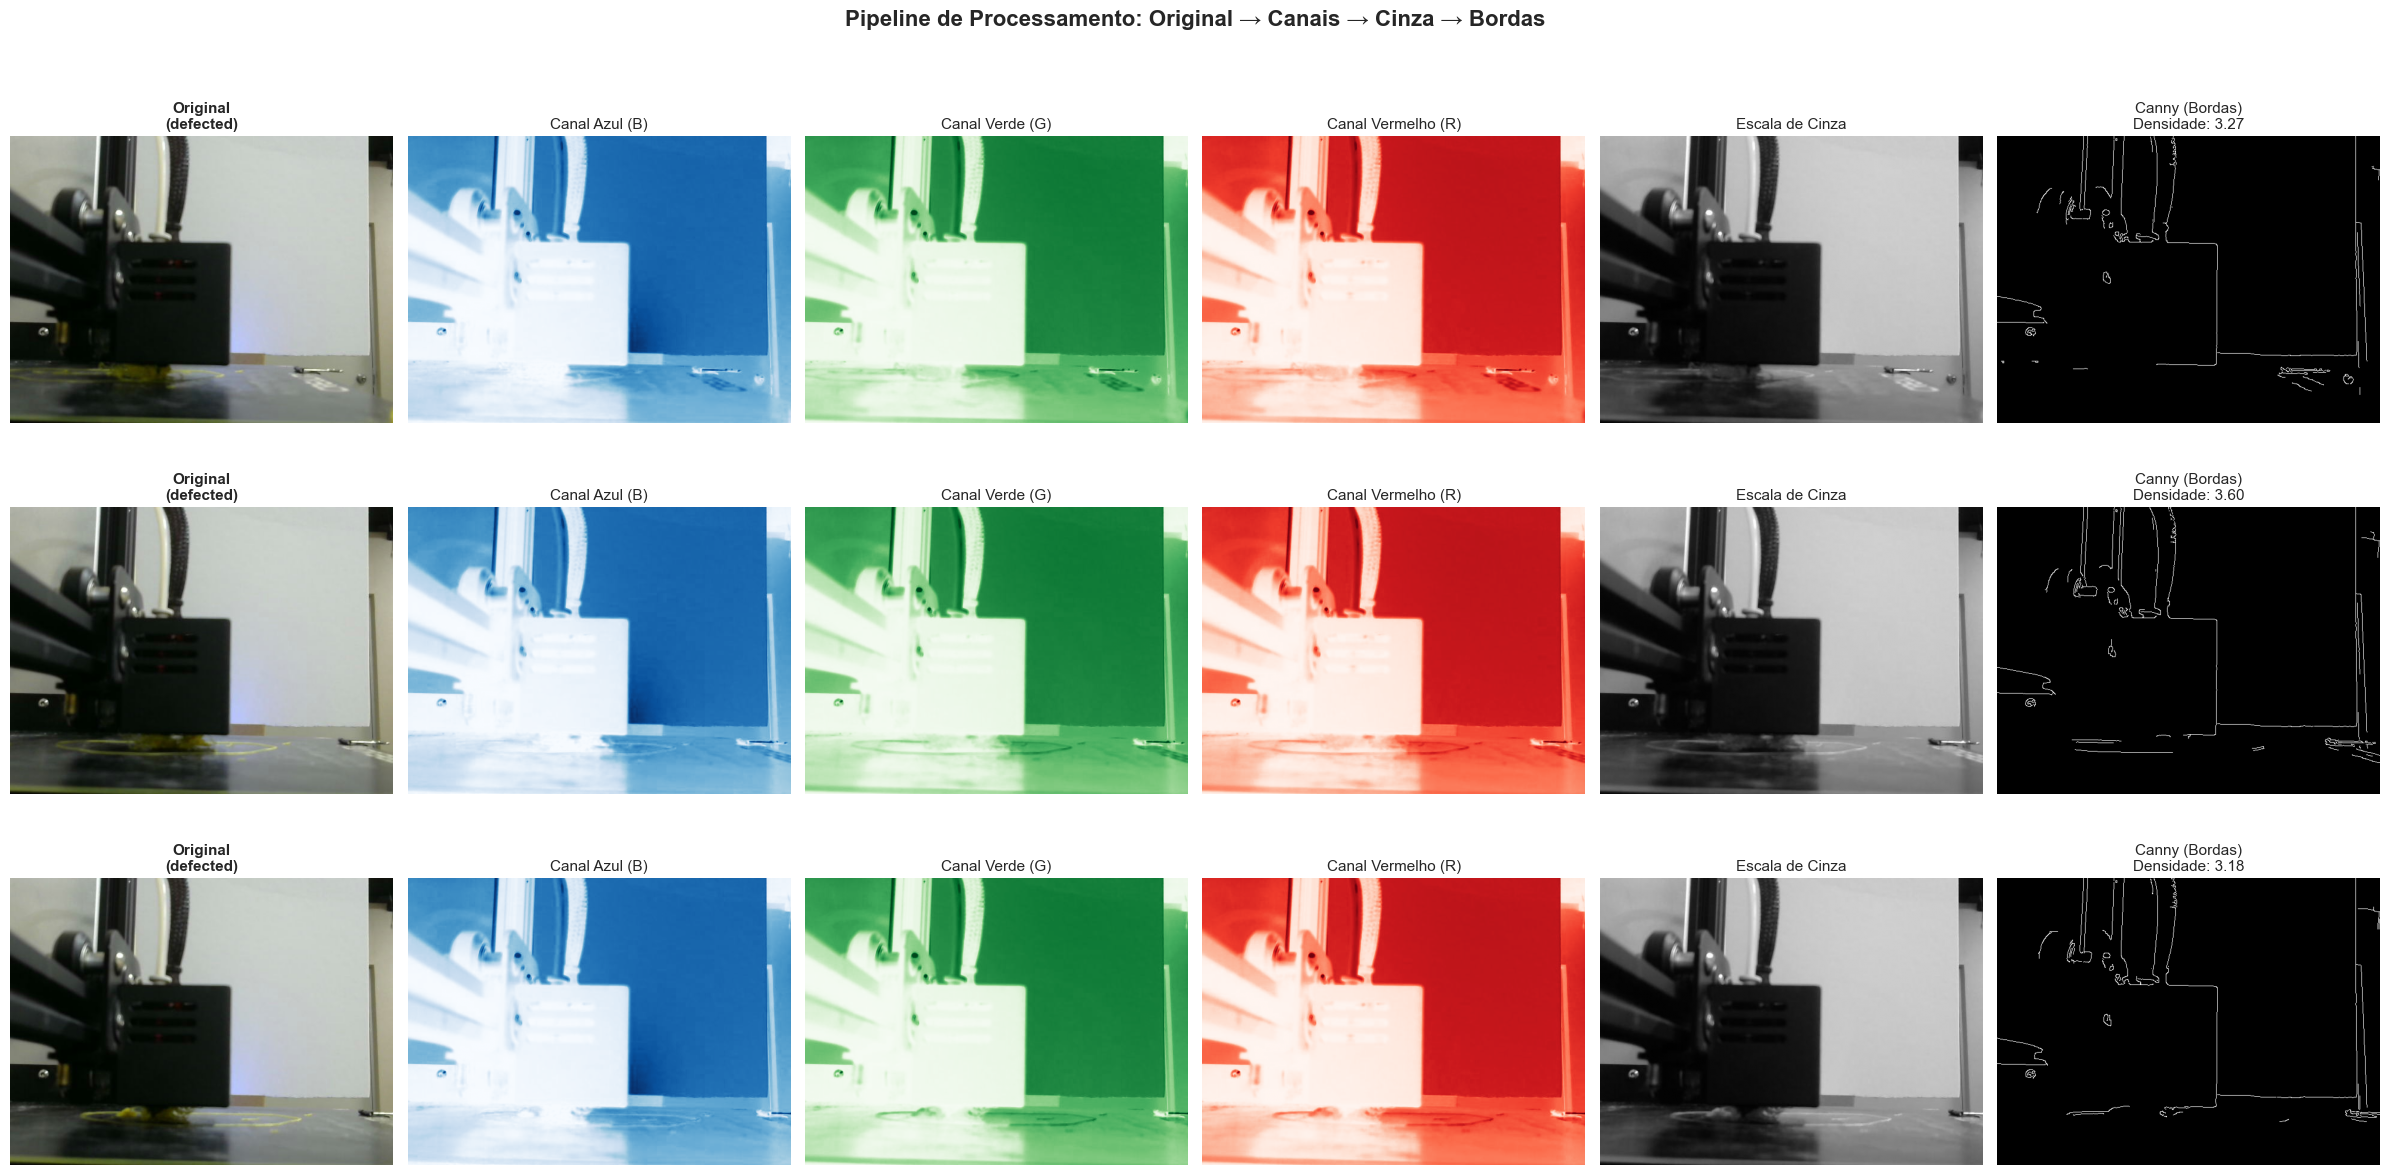

In [18]:
# 📊 Visualização dos Filtros - Passo a Passo
if sample_files:
    # Escolhe imagens de classes diferentes para comparação
    classes_seen = {}
    for f in sample_files:
        cls = f.parent.name
        if cls not in classes_seen:
            classes_seen[cls] = f
        if len(classes_seen) >= 3:
            break

    sample_images = list(classes_seen.values())[:3]
    if len(sample_images) < 3:
        sample_images = sample_files[:3]

    fig, axes = plt.subplots(len(sample_images), 6, figsize=(24, 4 * len(sample_images)))
    if len(sample_images) == 1:
        axes = [axes]

    for row, img_path in enumerate(sample_images):
        img_bgr = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, 100, 200)

        class_name = img_path.parent.name

        # 1. Imagem Original
        axes[row][0].imshow(img_rgb)
        axes[row][0].set_title(f"Original\n({class_name})", fontsize=11, fontweight='bold')
        axes[row][0].axis('off')

        # 2. Canal Azul (Blue)
        axes[row][1].imshow(img_bgr[:,:,0], cmap='Blues')
        axes[row][1].set_title("Canal Azul (B)", fontsize=11)
        axes[row][1].axis('off')

        # 3. Canal Verde (Green)
        axes[row][2].imshow(img_bgr[:,:,1], cmap='Greens')
        axes[row][2].set_title("Canal Verde (G)", fontsize=11)
        axes[row][2].axis('off')

        # 4. Canal Vermelho (Red)
        axes[row][3].imshow(img_bgr[:,:,2], cmap='Reds')
        axes[row][3].set_title("Canal Vermelho (R)", fontsize=11)
        axes[row][3].axis('off')

        # 5. Escala de Cinza
        axes[row][4].imshow(gray, cmap='gray')
        axes[row][4].set_title("Escala de Cinza", fontsize=11)
        axes[row][4].axis('off')

        # 6. Filtro Canny (Bordas)
        axes[row][5].imshow(edges, cmap='gray')
        edge_density = np.sum(edges) / (edges.shape[0] * edges.shape[1])
        axes[row][5].set_title(f"Canny (Bordas)\nDensidade: {edge_density:.2f}", fontsize=11)
        axes[row][5].axis('off')

    plt.suptitle("Pipeline de Processamento: Original → Canais → Cinza → Bordas",
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("Dataset não encontrado.")

### 🎛️ Impacto dos Limiares do Filtro Canny

O filtro Canny usa dois limiares (`threshold1` e `threshold2`) para decidir o que é borda. Veja como diferentes valores afetam o resultado:
- **Limiares baixos**: detecta muitas bordas (mais ruído)
- **Limiares altos**: detecta poucas bordas (mais seletivo)

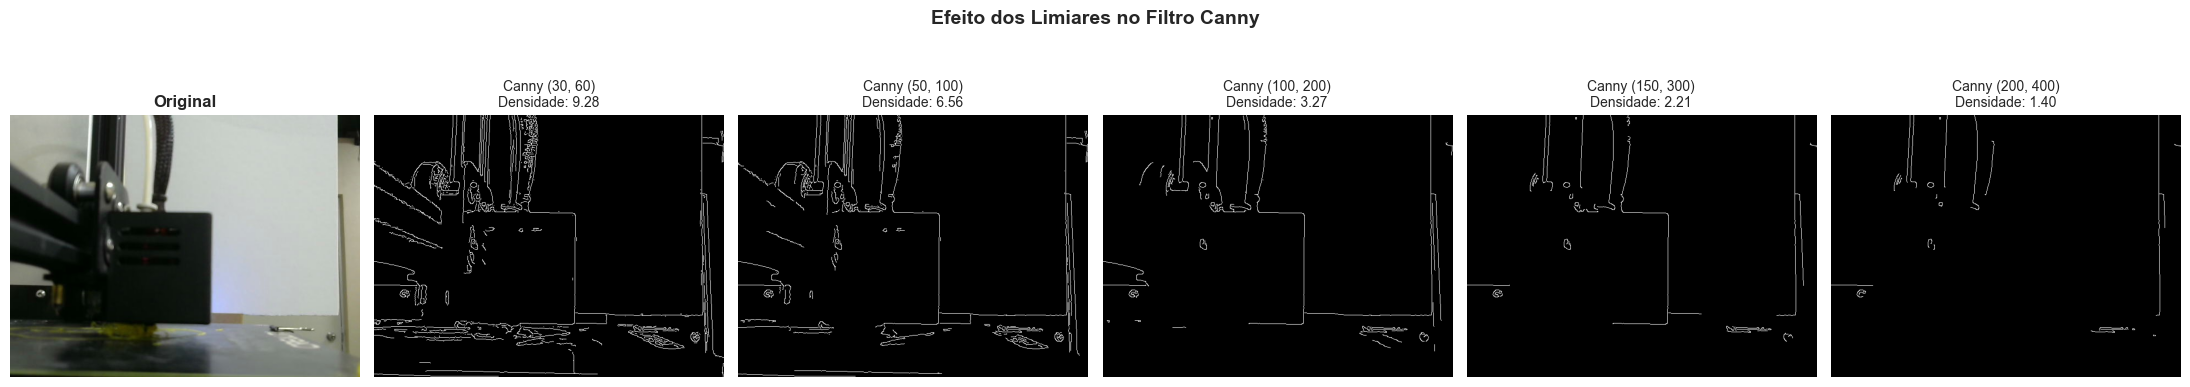

In [14]:
# 🎛️ Comparação de diferentes limiares do Canny
if sample_files:
    img_bgr = cv2.imread(str(sample_files[0]))
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    thresholds = [(30, 60), (50, 100), (100, 200), (150, 300), (200, 400)]

    fig, axes = plt.subplots(1, len(thresholds) + 1, figsize=(22, 4))

    axes[0].imshow(img_rgb)
    axes[0].set_title("Original", fontsize=12, fontweight='bold')
    axes[0].axis('off')

    for i, (t1, t2) in enumerate(thresholds):
        edges = cv2.Canny(gray, t1, t2)
        density = np.sum(edges) / (edges.shape[0] * edges.shape[1])
        axes[i+1].imshow(edges, cmap='gray')
        axes[i+1].set_title(f"Canny ({t1}, {t2})\nDensidade: {density:.2f}", fontsize=10)
        axes[i+1].axis('off')

    plt.suptitle("Efeito dos Limiares no Filtro Canny", fontsize=14, fontweight='bold', y=1.05)
    plt.tight_layout()
    plt.show()

### 📊 Histogramas de Cor por Classe

O histograma mostra a **distribuição dos valores de pixel** (0-255) para cada canal de cor. Classes diferentes podem ter distribuições diferentes — por exemplo, peças com defeito podem ter mais variação de cor.

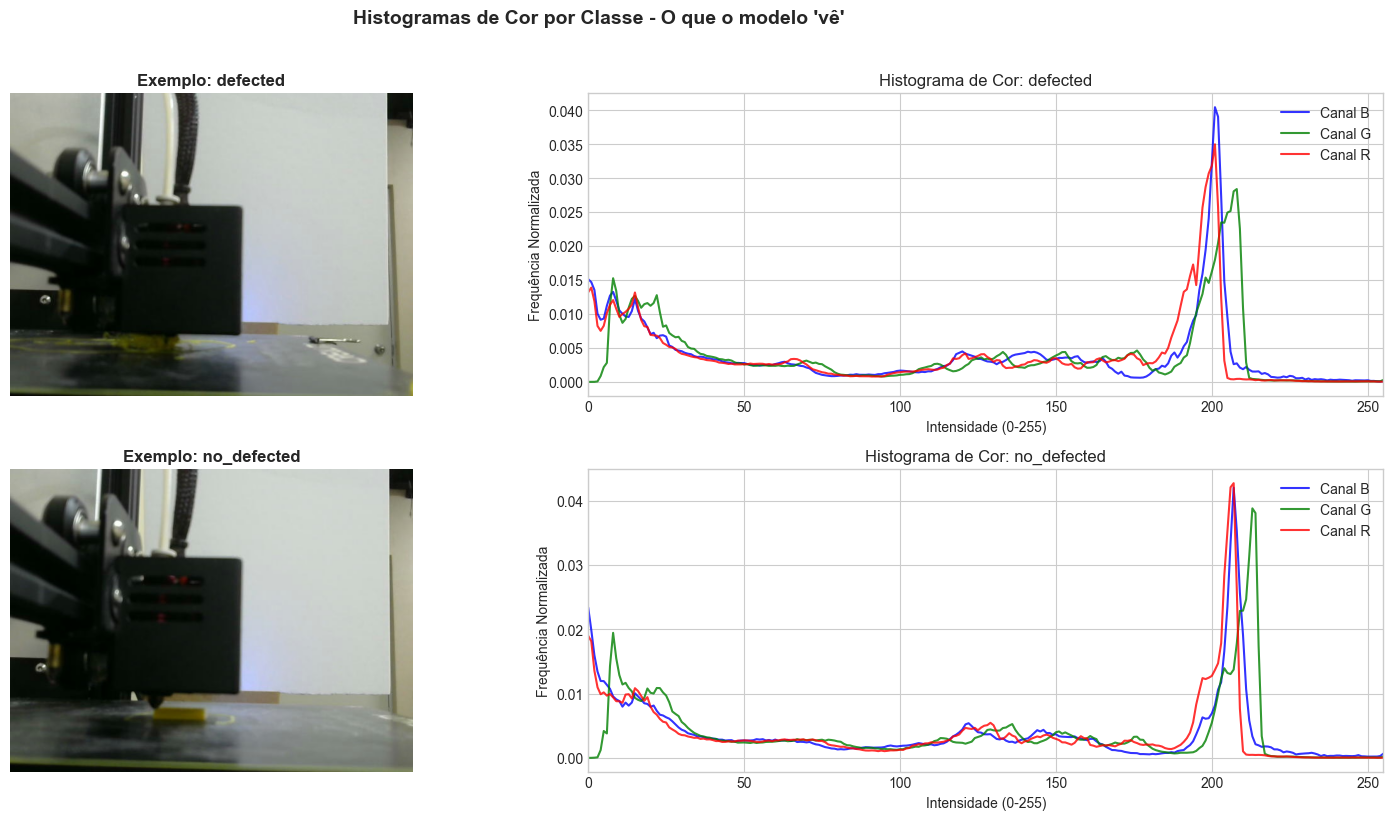

In [19]:
# 📊 Histogramas de Cor - Comparação entre classes
if sample_files:
    # Agrupa imagens por classe (pega até 5 de cada)
    class_images = {}
    for f in sample_files:
        cls = f.parent.name
        if cls not in class_images:
            class_images[cls] = []
        if len(class_images[cls]) < 5:
            class_images[cls].append(f)

    n_classes = len(class_images)
    fig, axes = plt.subplots(n_classes, 2, figsize=(16, 4 * n_classes))
    if n_classes == 1:
        axes = [axes]

    colors_bgr = ['blue', 'green', 'red']

    for idx, (cls_name, imgs) in enumerate(class_images.items()):
        # Mostra uma imagem exemplo
        img_bgr = cv2.imread(str(imgs[0]))
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        axes[idx][0].imshow(img_rgb)
        axes[idx][0].set_title(f"Exemplo: {cls_name}", fontsize=12, fontweight='bold')
        axes[idx][0].axis('off')

        # Histograma médio de todas as imagens desta classe
        for c_idx, color in enumerate(colors_bgr):
            all_hists = []
            for img_path in imgs:
                img = cv2.imread(str(img_path))
                if img is not None:
                    hist = cv2.calcHist([img], [c_idx], None, [256], [0, 256]).flatten()
                    hist = hist / hist.sum()  # Normaliza
                    all_hists.append(hist)

            if all_hists:
                mean_hist = np.mean(all_hists, axis=0)
                axes[idx][1].plot(mean_hist, color=color, alpha=0.8, label=f'Canal {color.upper()[0]}')

        axes[idx][1].set_title(f"Histograma de Cor: {cls_name}", fontsize=12)
        axes[idx][1].set_xlabel("Intensidade (0-255)")
        axes[idx][1].set_ylabel("Frequência Normalizada")
        axes[idx][1].legend()
        axes[idx][1].set_xlim([0, 255])

    plt.suptitle("Histogramas de Cor por Classe - O que o modelo 'vê'",
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

### Construção do Dataset Tabular
Vamos iterar sobre todas as imagens e criar um DataFrame: `[Feature1, Feature2, ..., FeatureN, Label]`

In [20]:
def build_tabular_dataset(base_path):
    data = []
    labels = []

    if not base_path.exists():
        print("Dataset não encontrado.")
        return None, None

    print("Extraindo features (isso pode levar alguns segundos)...")

    for folder in base_path.iterdir():
        if folder.is_dir():
            class_name = folder.name
            images = list(folder.glob("*.jpg")) + list(folder.glob("*.png"))

            for img_path in images:
                feats = extract_features(img_path)
                if feats is not None:
                    data.append(feats)
                    labels.append(class_name)

    return np.array(data), np.array(labels)

X, y = build_tabular_dataset(DATASET_PATH)

if X is not None:
    print(f"Dataset construído: {X.shape[0]} amostras, {X.shape[1]} atributos.")

Extraindo features (isso pode levar alguns segundos)...
Dataset construído: 1482 amostras, 7 atributos.


### 🧮 Visualização da Matriz de Features

Cada imagem vira uma **linha** na matriz. Cada coluna é uma feature extraída:
| Feature | Descrição |
|---------|-----------|
| `mean_B`, `mean_G`, `mean_R` | Cor média de cada canal |
| `std_B`, `std_G`, `std_R` | Desvio padrão (contraste) de cada canal |
| `edge_density` | Proporção de pixels de borda (Canny) |

Vamos visualizar essa matriz como um **heatmap** e como **distribuições** para entender como as classes se separam.

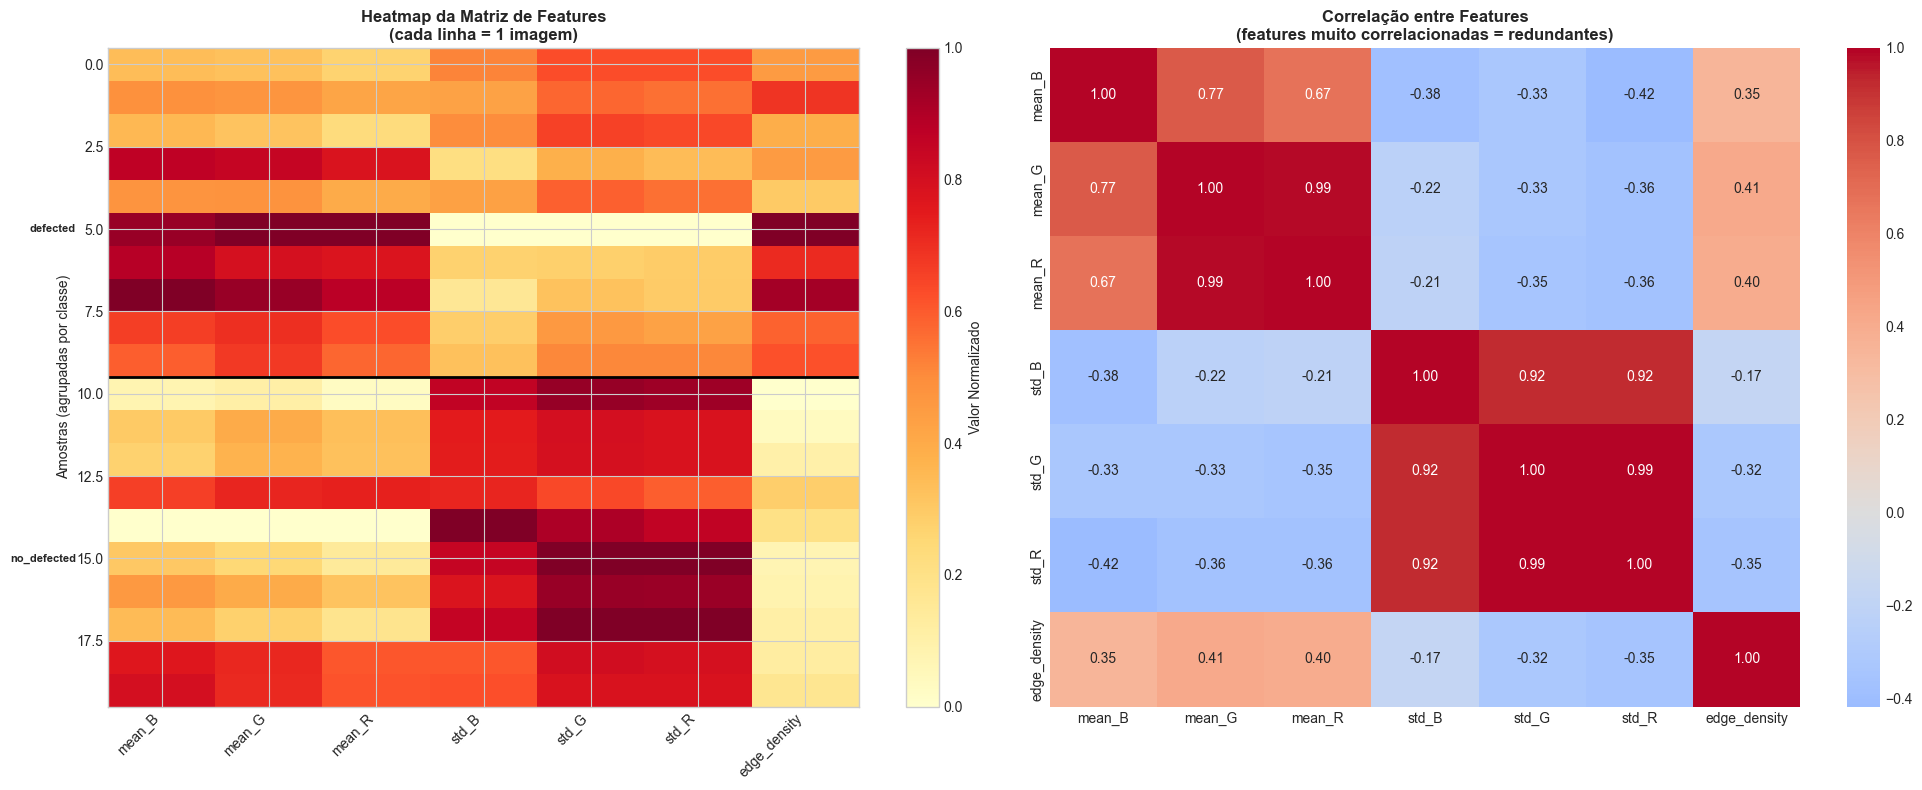


📋 Estatísticas Descritivas por Classe:


mean_B  mean_G  mean_R  std_B  std_G  std_R  edge_density
Classe                                                                
defected     110.07  118.98  114.59  80.10  76.98  76.93          3.64
no_defected  107.69  116.81  112.47  82.41  80.32  80.54          3.44

In [21]:
# 🧮 Visualização da Matriz de Features
if X is not None:
    feature_names = ['mean_B', 'mean_G', 'mean_R', 'std_B', 'std_G', 'std_R', 'edge_density']
    df = pd.DataFrame(X, columns=feature_names)
    df['Classe'] = y

    # 1. Heatmap da Matriz (primeiras 30 amostras)
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Amostra por classe para o heatmap
    sample_indices = []
    for cls in np.unique(y):
        cls_idx = np.where(y == cls)[0][:10]
        sample_indices.extend(cls_idx)

    X_sample = X[sample_indices]
    y_sample = y[sample_indices]

    # Normaliza para o heatmap (0-1)
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    X_norm = scaler.fit_transform(X_sample)

    im = axes[0].imshow(X_norm, aspect='auto', cmap='YlOrRd', interpolation='nearest')
    axes[0].set_xticks(range(len(feature_names)))
    axes[0].set_xticklabels(feature_names, rotation=45, ha='right')
    axes[0].set_ylabel("Amostras (agrupadas por classe)")
    axes[0].set_title("Heatmap da Matriz de Features\n(cada linha = 1 imagem)", fontsize=12, fontweight='bold')

    # Adiciona separadores de classe
    current_pos = 0
    for cls in np.unique(y_sample):
        count = np.sum(y_sample == cls)
        mid = current_pos + count / 2
        axes[0].text(-0.8, mid, cls, fontsize=8, va='center', ha='right', fontweight='bold')
        current_pos += count
        if current_pos < len(y_sample):
            axes[0].axhline(y=current_pos - 0.5, color='black', linewidth=2)

    plt.colorbar(im, ax=axes[0], label='Valor Normalizado')

    # 2. Matriz de Correlação entre Features
    corr = df[feature_names].corr()
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=axes[1],
                xticklabels=feature_names, yticklabels=feature_names)
    axes[1].set_title("Correlação entre Features\n(features muito correlacionadas = redundantes)",
                      fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # 3. Estatísticas descritivas
    print("\n📋 Estatísticas Descritivas por Classe:")
    print("=" * 80)
    display(df.groupby('Classe')[feature_names].mean().round(2))

C:\Users\44057824820\AppData\Local\Temp\ipykernel_13136\3367329945.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Classe', y=feat, ax=axes[i], palette=colors)
C:\Users\44057824820\AppData\Local\Temp\ipykernel_13136\3367329945.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Classe', y=feat, ax=axes[i], palette=colors)
C:\Users\44057824820\AppData\Local\Temp\ipykernel_13136\3367329945.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Classe', y=feat, ax=axes[i], palette=colors)
C:\Users\4405782

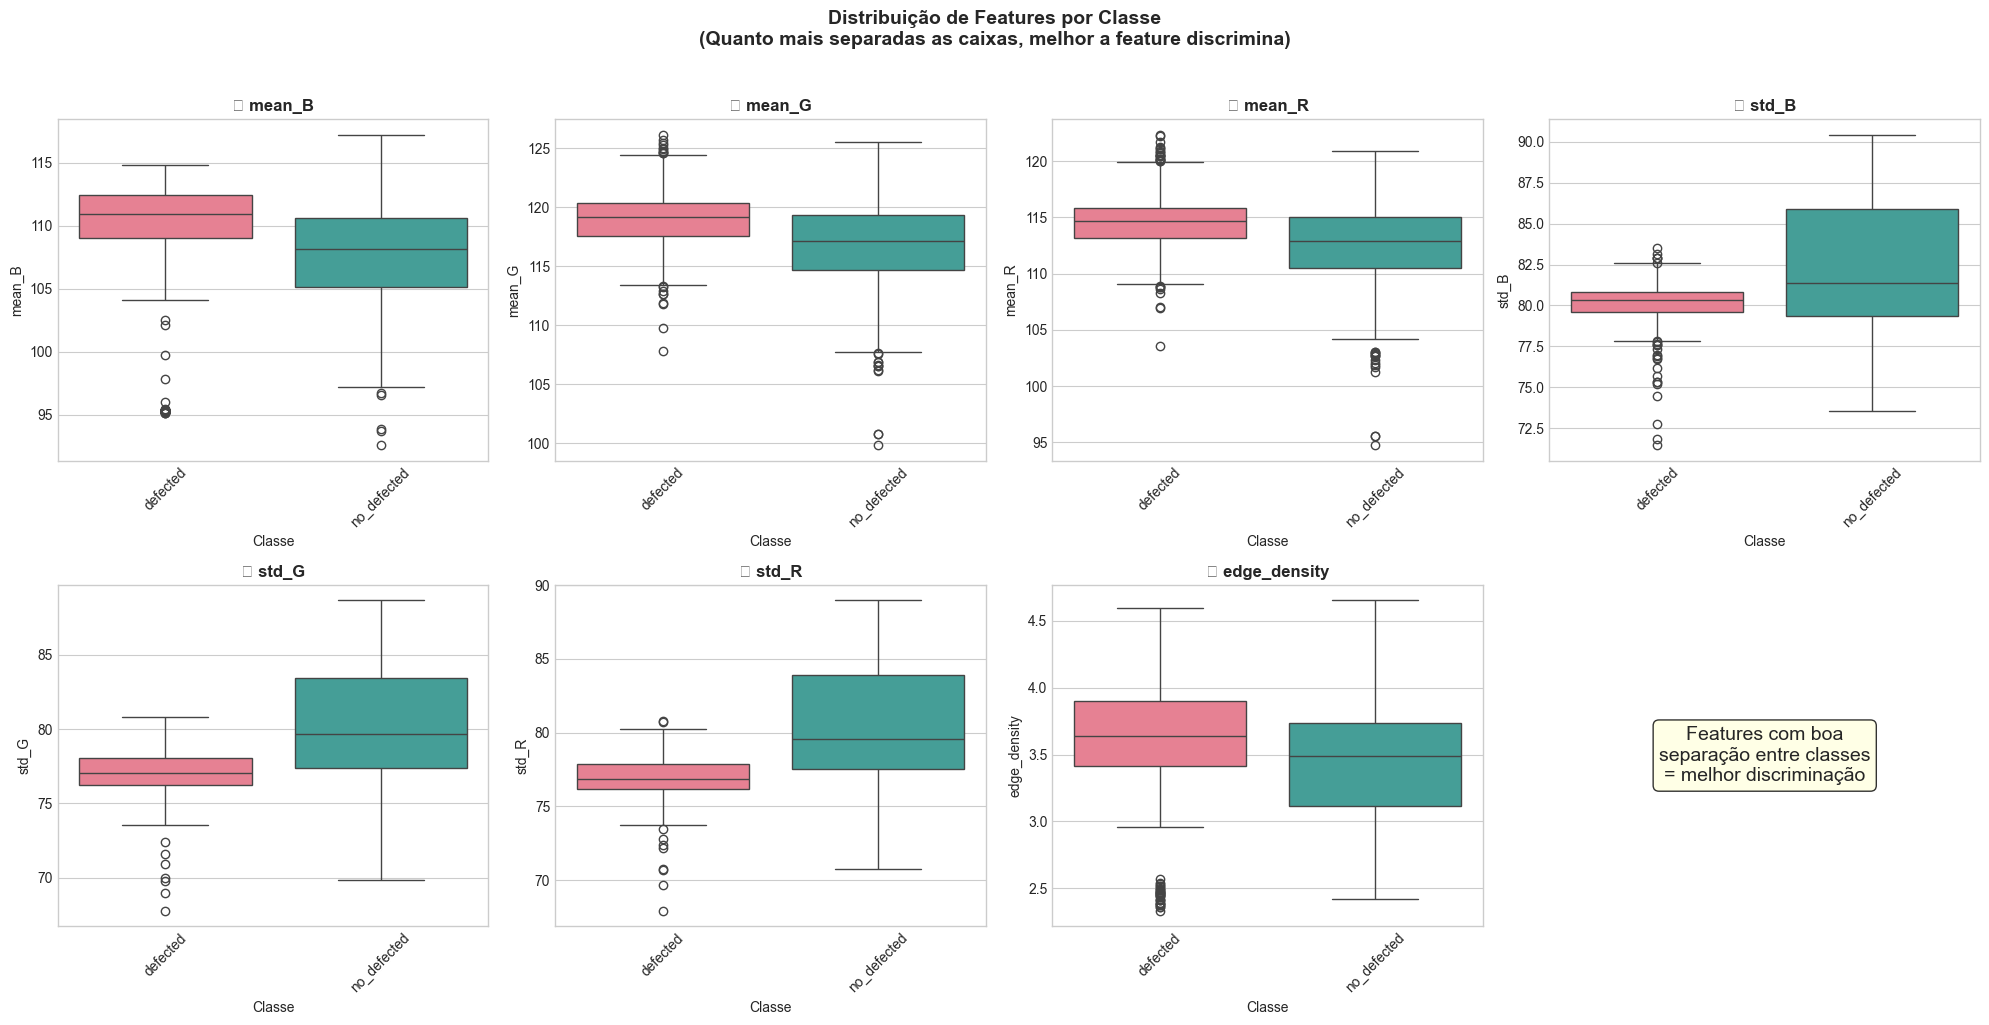

In [22]:
# 📦 Distribuição de cada Feature por Classe (Boxplots)
if X is not None:
    feature_names = ['mean_B', 'mean_G', 'mean_R', 'std_B', 'std_G', 'std_R', 'edge_density']
    df = pd.DataFrame(X, columns=feature_names)
    df['Classe'] = y

    n_features = len(feature_names)
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()

    colors = sns.color_palette("husl", len(np.unique(y)))

    for i, feat in enumerate(feature_names):
        sns.boxplot(data=df, x='Classe', y=feat, ax=axes[i], palette=colors)
        axes[i].set_title(f"📦 {feat}", fontsize=12, fontweight='bold')
        axes[i].tick_params(axis='x', rotation=45)

    # Remove último subplot vazio
    axes[-1].axis('off')
    axes[-1].text(0.5, 0.5, "Features com boa\nseparação entre classes\n= melhor discriminação",
                  fontsize=14, ha='center', va='center',
                  bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

    plt.suptitle("Distribuição de Features por Classe\n(Quanto mais separadas as caixas, melhor a feature discrimina)",
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

---

## 3. Treinamento de Modelo Local

Com `X` (features) e `y` (rótulos), virou um problema clássico de Machine Learning. Vamos usar SVM e Random Forest.

=== Random Forest ===
              precision    recall  f1-score   support

    defected       0.96      0.97      0.96       207
 no_defected       0.97      0.96      0.97       238

    accuracy                           0.96       445
   macro avg       0.96      0.96      0.96       445
weighted avg       0.96      0.96      0.96       445



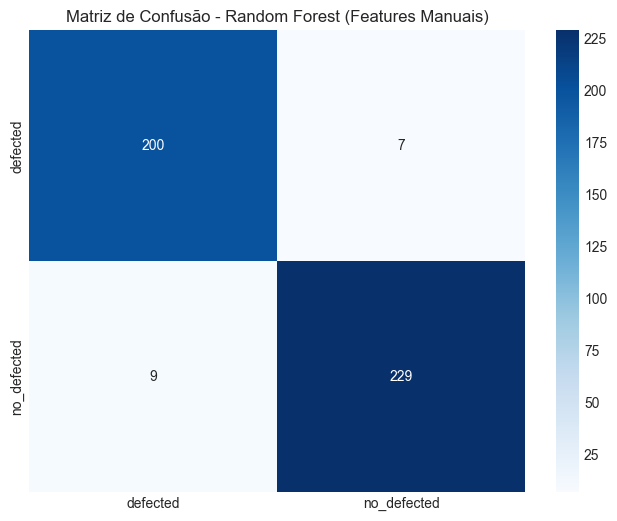

In [23]:
if X is not None:
    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Modelo 1: Random Forest
    clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf_rf.fit(X_train, y_train)
    y_pred_rf = clf_rf.predict(X_test)

    print("=== Random Forest ===")
    print(classification_report(y_test, y_pred_rf))

    # Matriz de Confusão
    cm = confusion_matrix(y_test, y_pred_rf)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.title("Matriz de Confusão - Random Forest (Features Manuais)")
    plt.show()

### 🌲 Como o Random Forest Funciona?

O Random Forest é um **ensemble** de árvores de decisão:
1. Cria múltiplas árvores, cada uma treinada com uma **amostra aleatória** dos dados
2. Cada árvore "vota" na classe da imagem
3. A classe com **mais votos** vence

Vamos visualizar:
- **Importância das Features**: Quais atributos o modelo mais usou para decidir?
- **Confiança das Predições**: Quão "seguro" o modelo está?
- **Comparação SVM vs Random Forest**: Qual modelo performa melhor?

C:\Users\44057824820\AppData\Local\Temp\ipykernel_13136\1682950569.py:55: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\44057824820\AppData\Local\Temp\ipykernel_13136\1682950569.py:55: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\44057824820\AppData\Local\Temp\ipykernel_13136\1682950569.py:55: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\44057824820\AppData\Roaming\Python\Python314\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\44057824820\AppData\Roaming\Python\Python314\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\44057824820\AppData\Roaming\Python\Python314\

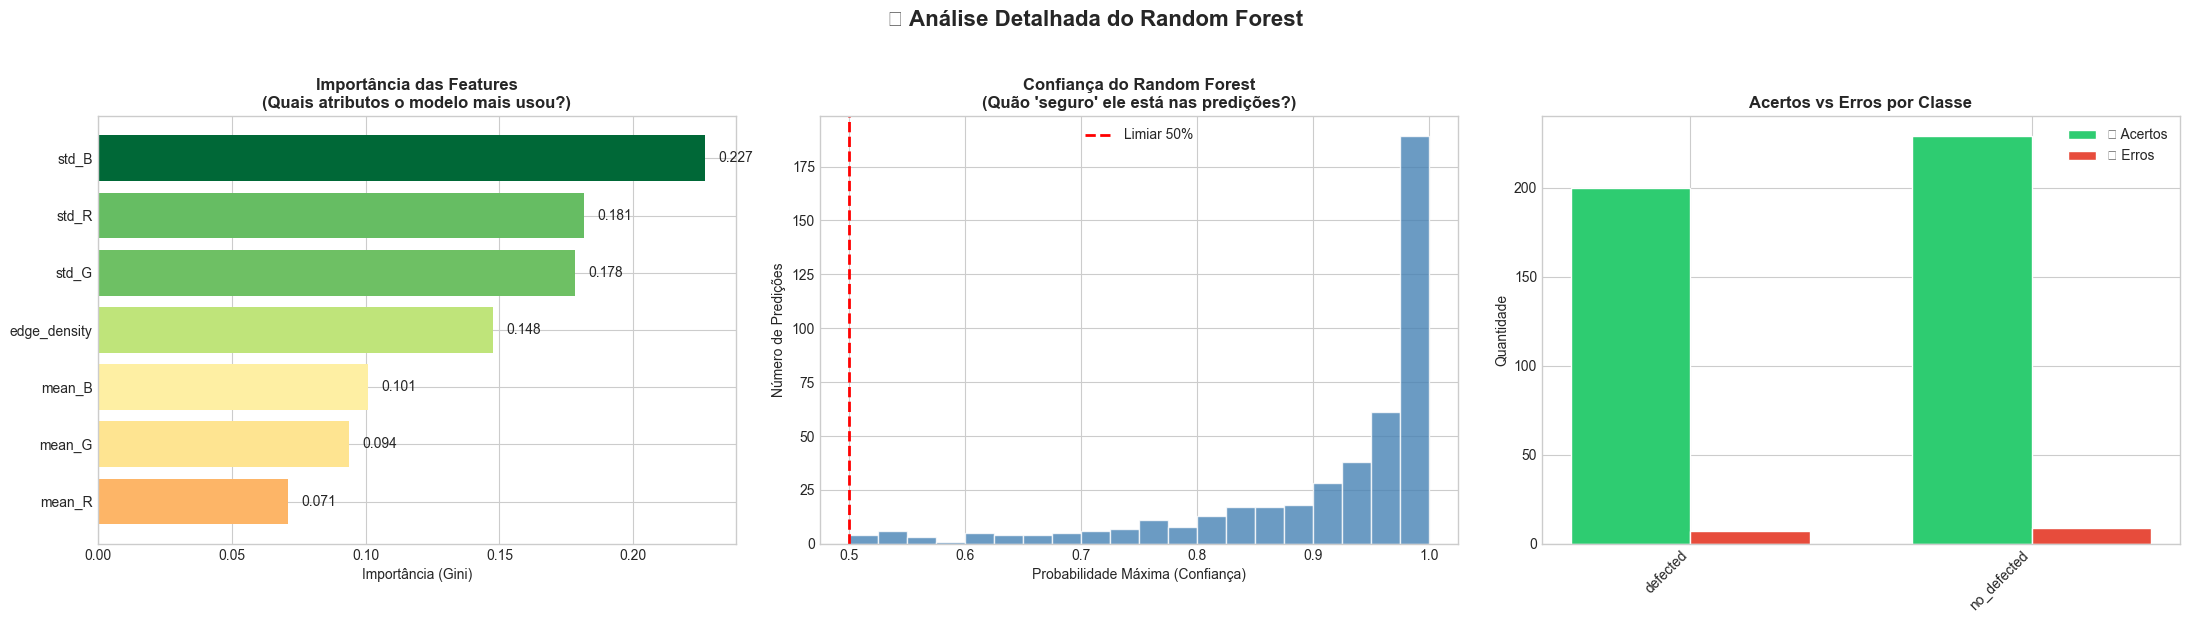

In [24]:
# 🌲 Importância das Features no Random Forest
if X is not None:
    feature_names = ['mean_B', 'mean_G', 'mean_R', 'std_B', 'std_G', 'std_R', 'edge_density']

    fig, axes = plt.subplots(1, 3, figsize=(22, 6))

    # 1. Importância das Features (Gini)
    importances = clf_rf.feature_importances_
    indices = np.argsort(importances)[::-1]

    colors = plt.cm.RdYlGn(importances[indices] / importances[indices].max())
    bars = axes[0].barh(range(len(feature_names)), importances[indices], color=colors)
    axes[0].set_yticks(range(len(feature_names)))
    axes[0].set_yticklabels([feature_names[i] for i in indices])
    axes[0].set_xlabel("Importância (Gini)")
    axes[0].set_title("Importância das Features\n(Quais atributos o modelo mais usou?)",
                      fontsize=12, fontweight='bold')
    axes[0].invert_yaxis()

    # Adiciona valores nas barras
    for bar, val in zip(bars, importances[indices]):
        axes[0].text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
                    f'{val:.3f}', va='center', fontsize=10)

    # 2. Confiança das Predições (Probabilidades)
    y_proba = clf_rf.predict_proba(X_test)
    max_proba = y_proba.max(axis=1)

    axes[1].hist(max_proba, bins=20, color='steelblue', edgecolor='white', alpha=0.8)
    axes[1].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Limiar 50%')
    axes[1].set_xlabel("Probabilidade Máxima (Confiança)")
    axes[1].set_ylabel("Número de Predições")
    axes[1].set_title("Confiança do Random Forest\n(Quão 'seguro' ele está nas predições?)",
                      fontsize=12, fontweight='bold')
    axes[1].legend()

    # 3. Acertos vs Erros por Classe
    correct = y_pred_rf == y_test
    classes = np.unique(y)

    acertos = [np.sum((y_test == cls) & correct) for cls in classes]
    erros = [np.sum((y_test == cls) & ~correct) for cls in classes]

    x_pos = np.arange(len(classes))
    width = 0.35
    axes[2].bar(x_pos - width/2, acertos, width, label='✅ Acertos', color='#2ecc71', edgecolor='white')
    axes[2].bar(x_pos + width/2, erros, width, label='❌ Erros', color='#e74c3c', edgecolor='white')
    axes[2].set_xticks(x_pos)
    axes[2].set_xticklabels(classes, rotation=45, ha='right')
    axes[2].set_ylabel("Quantidade")
    axes[2].set_title("Acertos vs Erros por Classe", fontsize=12, fontweight='bold')
    axes[2].legend()

    plt.suptitle("🌲 Análise Detalhada do Random Forest", fontsize=16, fontweight='bold', y=1.03)
    plt.tight_layout()
    plt.show()

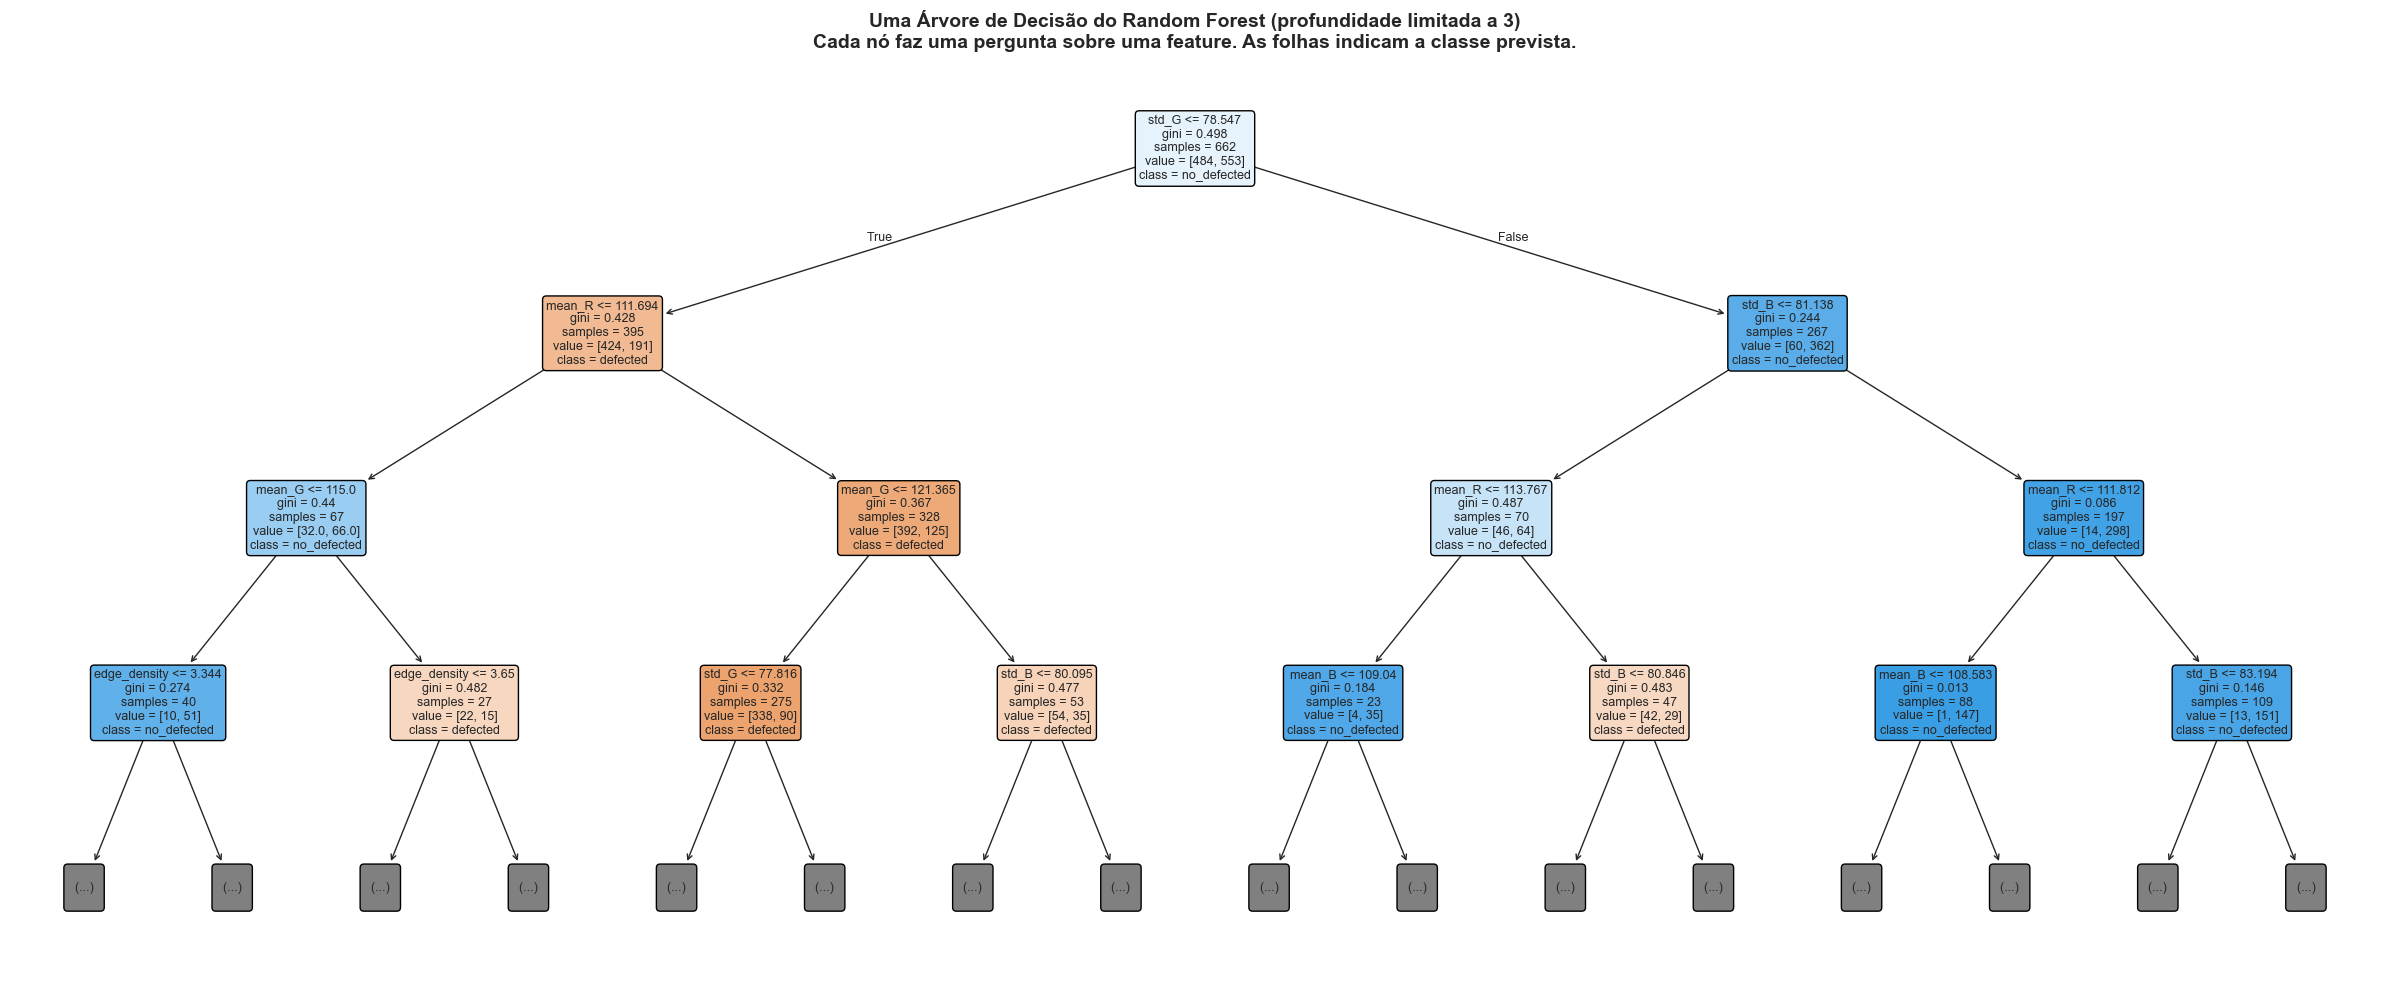

O Random Forest tem 100 árvores como esta.
Cada árvore 'vota' e a classe com mais votos vence!


In [25]:
# 🌳 Visualização de uma Árvore de Decisão individual do Random Forest
if X is not None:
    from sklearn.tree import plot_tree

    feature_names = ['mean_B', 'mean_G', 'mean_R', 'std_B', 'std_G', 'std_R', 'edge_density']

    fig, ax = plt.subplots(figsize=(24, 10))

    # Pega a primeira árvore da floresta (limitando a profundidade para legibilidade)
    tree = clf_rf.estimators_[0]

    plot_tree(tree,
              feature_names=feature_names,
              class_names=list(np.unique(y)),
              filled=True,
              rounded=True,
              max_depth=3,  # Limita profundidade para visualização
              fontsize=9,
              ax=ax)

    ax.set_title("Uma Árvore de Decisão do Random Forest (profundidade limitada a 3)\n"
                 "Cada nó faz uma pergunta sobre uma feature. As folhas indicam a classe prevista.",
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print(f"O Random Forest tem {len(clf_rf.estimators_)} árvores como esta.")
    print(f"Cada árvore 'vota' e a classe com mais votos vence!")

### ⚔️ Comparação: SVM vs Random Forest

Agora vamos treinar um **SVM (Support Vector Machine)** e comparar com o Random Forest.

### Como o SVM funciona?

O SVM tenta encontrar a **melhor linha (ou hiperplano) de separação** entre as classes. Imagine os dados como pontos num gráfico:

```
         Classe A (defeituosa)        Classe B (sem defeito)
              x x x                        o o o
            x x x x x          |         o o o o o
              x x x            |           o o o
                               |
                          FRONTEIRA
```

O SVM encontra a fronteira que **maximiza a distância** entre as classes. Os pontos mais próximos da fronteira são chamados de **vetores de suporte** — são eles que definem onde a linha fica.

### O que é o Kernel RBF?

Muitas vezes os dados **não são separáveis por uma linha reta**. O kernel RBF ("Radial Basis Function") resolve isso: ele "projeta" os dados para um espaço de dimensão mais alta onde uma separação linear é possível.

> **Analogia:** Imagine moedas misturadas numa mesa (não dá para separar com uma régua). Agora jogue as moedas para cima — no ar, a diferentes alturas, dá para passar uma folha de papel entre elas. O kernel faz algo parecido matematicamente.

### Por que o SVM precisa de normalização?

O SVM calcula **distâncias** entre pontos. Se uma feature vai de 0 a 255 (cor média) e outra de 0 a 1 (edge_density), a feature maior **domina** o cálculo de distância, e a menor é praticamente ignorada.

O `StandardScaler` resolve isso colocando todas as features na **mesma escala** (média 0, desvio padrão 1):

| Antes (sem normalizar) | Depois (com StandardScaler) |
|---|---|
| mean_B: 120.5 | mean_B: 0.32 |
| mean_G: 95.3 | mean_G: -0.18 |
| edge_density: 0.04 | edge_density: -0.75 |

O Random Forest **não precisa** de normalização porque ele trabalha com "perguntas" (ex: `mean_B > 100?`) — a escala não importa.

### Diferenças principais: SVM vs Random Forest

| Aspecto | Random Forest | SVM (RBF) |
|---|---|---|
| **Como decide** | Votação de 100 árvores | Fronteira de máxima margem |
| **Normalização** | Não precisa | Obrigatório |
| **Interpretabilidade** | Alta (vê as árvores) | Baixa (caixa preta) |
| **Velocidade de treino** | Rápido | Pode ser lento com muitos dados |
| **Confiança** | Sim (`predict_proba`) | Não nativo (usa `decision_function`) |

Vamos treinar o SVM e comparar os dois lado a lado:

=== SVM (RBF Kernel) ===
              precision    recall  f1-score   support

    defected       0.92      0.93      0.93       207
 no_defected       0.94      0.93      0.93       238

    accuracy                           0.93       445
   macro avg       0.93      0.93      0.93       445
weighted avg       0.93      0.93      0.93       445



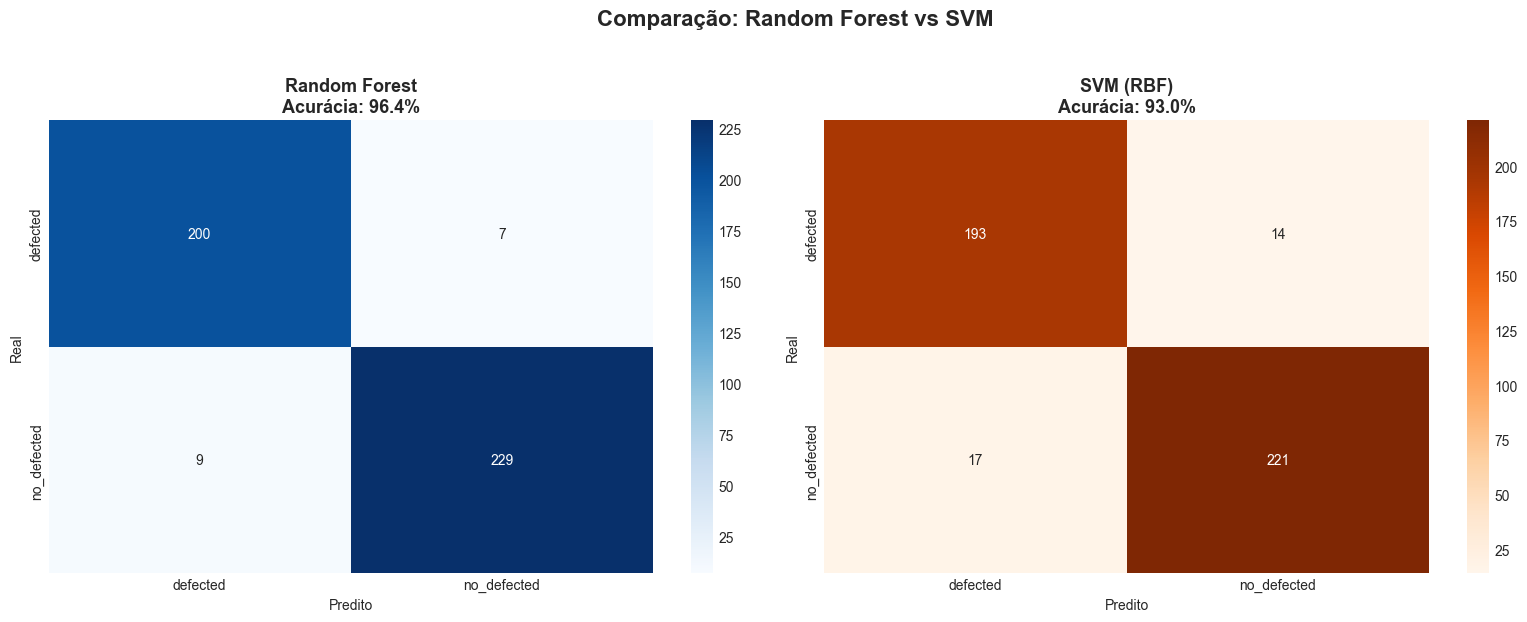


Resumo:
   Random Forest: 96.4% de acurácia
   SVM (RBF):     93.0% de acurácia
   Vencedor: Random Forest


In [26]:
# ⚔️ Comparação SVM vs Random Forest
if X is not None:
    from sklearn.preprocessing import StandardScaler

    # SVM precisa de features normalizadas
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Treina SVM
    clf_svm = SVC(kernel='rbf', random_state=42)
    clf_svm.fit(X_train_scaled, y_train)
    y_pred_svm = clf_svm.predict(X_test_scaled)

    print("=== SVM (RBF Kernel) ===")
    print(classification_report(y_test, y_pred_svm))

    # Comparação lado a lado
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    classes = np.unique(y)

    # Matriz de Confusão - Random Forest
    cm_rf = confusion_matrix(y_test, y_pred_rf)
    sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=classes, yticklabels=classes)
    acc_rf = np.sum(y_pred_rf == y_test) / len(y_test)
    axes[0].set_title(f"Random Forest\nAcurácia: {acc_rf:.1%}", fontsize=13, fontweight='bold')
    axes[0].set_xlabel("Predito")
    axes[0].set_ylabel("Real")

    # Matriz de Confusão - SVM
    cm_svm = confusion_matrix(y_test, y_pred_svm)
    sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
                xticklabels=classes, yticklabels=classes)
    acc_svm = np.sum(y_pred_svm == y_test) / len(y_test)
    axes[1].set_title(f"SVM (RBF)\nAcurácia: {acc_svm:.1%}", fontsize=13, fontweight='bold')
    axes[1].set_xlabel("Predito")
    axes[1].set_ylabel("Real")

    plt.suptitle("Comparação: Random Forest vs SVM", fontsize=16, fontweight='bold', y=1.03)
    plt.tight_layout()
    plt.show()

    # Resumo
    print(f"\nResumo:")
    print(f"   Random Forest: {acc_rf:.1%} de acurácia")
    print(f"   SVM (RBF):     {acc_svm:.1%} de acurácia")
    winner = "Random Forest" if acc_rf > acc_svm else "SVM" if acc_svm > acc_rf else "Empate!"
    print(f"   Vencedor: {winner}")

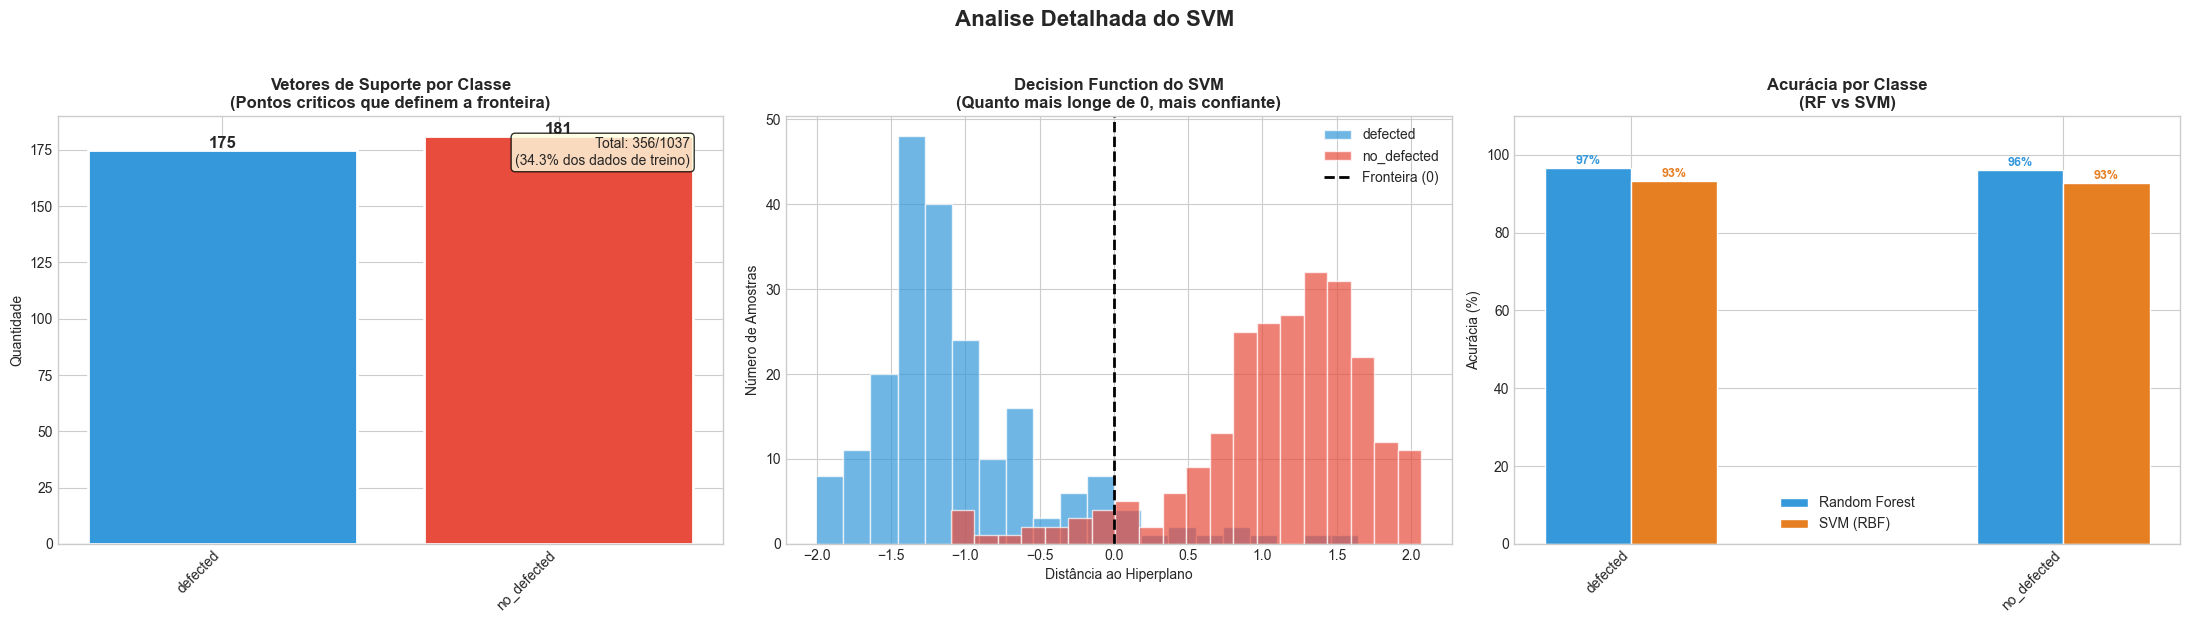

In [27]:
# ⚔️ Análise Detalhada do SVM
if X is not None:
    fig, axes = plt.subplots(1, 3, figsize=(22, 6))

    # 1. Vetores de Suporte por Classe
    n_support = clf_svm.n_support_
    classes = clf_svm.classes_
    colors_sv = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12'][:len(classes)]

    bars = axes[0].bar(range(len(classes)), n_support, color=colors_sv, edgecolor='white', linewidth=2)
    axes[0].set_xticks(range(len(classes)))
    axes[0].set_xticklabels(classes, rotation=45, ha='right')
    axes[0].set_ylabel("Quantidade")
    axes[0].set_title("Vetores de Suporte por Classe\n(Pontos criticos que definem a fronteira)",
                      fontsize=12, fontweight='bold')

    for bar, val in zip(bars, n_support):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    str(val), ha='center', fontsize=12, fontweight='bold')

    total_train = len(X_train)
    total_sv = sum(n_support)
    axes[0].text(0.95, 0.95,
                f"Total: {total_sv}/{total_train}\n({total_sv/total_train:.1%} dos dados de treino)",
                transform=axes[0].transAxes, ha='right', va='top', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

    # 2. Distância ao Hiperplano (Decision Function)
    dec_values = clf_svm.decision_function(X_test_scaled)

    if dec_values.ndim == 1:
        # Classificação binária
        axes[1].hist(dec_values[y_test == classes[0]], bins=20, alpha=0.7,
                    color='#3498db', edgecolor='white', label=classes[0])
        axes[1].hist(dec_values[y_test == classes[1]], bins=20, alpha=0.7,
                    color='#e74c3c', edgecolor='white', label=classes[1])
        axes[1].axvline(x=0, color='black', linestyle='--', linewidth=2, label='Fronteira (0)')
    else:
        # Multi-classe: usa a confiança máxima
        max_dec = np.max(np.abs(dec_values), axis=1)
        for i, cls in enumerate(classes):
            mask = y_test == cls
            axes[1].hist(max_dec[mask], bins=15, alpha=0.6,
                        color=colors_sv[i], edgecolor='white', label=cls)

    axes[1].set_xlabel("Distância ao Hiperplano")
    axes[1].set_ylabel("Número de Amostras")
    axes[1].set_title("Decision Function do SVM\n(Quanto mais longe de 0, mais confiante)",
                      fontsize=12, fontweight='bold')
    axes[1].legend()

    # 3. Comparação de Acertos/Erros - SVM vs RF lado a lado
    classes_list = list(np.unique(y))
    x_pos = np.arange(len(classes_list))
    width = 0.2

    acc_per_class_rf = []
    acc_per_class_svm = []
    for cls in classes_list:
        mask = y_test == cls
        acc_per_class_rf.append(np.mean(y_pred_rf[mask] == y_test[mask]) * 100)
        acc_per_class_svm.append(np.mean(y_pred_svm[mask] == y_test[mask]) * 100)

    bars_rf = axes[2].bar(x_pos - width/2, acc_per_class_rf, width,
                          label='Random Forest', color='#3498db', edgecolor='white')
    bars_svm = axes[2].bar(x_pos + width/2, acc_per_class_svm, width,
                           label='SVM (RBF)', color='#e67e22', edgecolor='white')

    axes[2].set_xticks(x_pos)
    axes[2].set_xticklabels(classes_list, rotation=45, ha='right')
    axes[2].set_ylabel("Acurácia (%)")
    axes[2].set_ylim(0, 110)
    axes[2].set_title("Acurácia por Classe\n(RF vs SVM)", fontsize=12, fontweight='bold')
    axes[2].legend()

    for bar, val in zip(bars_rf, acc_per_class_rf):
        axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f'{val:.0f}%', ha='center', fontsize=9, color='#3498db', fontweight='bold')
    for bar, val in zip(bars_svm, acc_per_class_svm):
        axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f'{val:.0f}%', ha='center', fontsize=9, color='#e67e22', fontweight='bold')

    plt.suptitle("Analise Detalhada do SVM", fontsize=16, fontweight='bold', y=1.03)
    plt.tight_layout()
    plt.show()

### O que os gráficos do SVM mostram?

**1. Vetores de Suporte por Classe:**
Os vetores de suporte são os exemplos **mais difíceis** — ficam na "zona cinzenta" entre as classes. Quanto **menos** vetores de suporte, mais clara é a separação entre as classes. Se quase todos os dados de treino são vetores de suporte, o modelo pode estar com dificuldade.

**2. Decision Function (Distância ao Hiperplano):**
O SVM não dá probabilidades como o Random Forest. Em vez disso, calcula a **distância** de cada ponto à fronteira de decisão:
- **Distância positiva** → classe A
- **Distância negativa** → classe B
- **Próximo de 0** → o modelo tem pouca certeza

> Quanto mais os histogramas das classes estiverem **separados** e **longe do zero**, melhor o SVM está a distinguir as classes.

**3. Acurácia por Classe (RF vs SVM):**
Compara diretamente quantas imagens cada modelo acertou em cada classe. É possível que um modelo seja melhor numa classe e pior noutra!

---

### 🔮 Predição em Novas Imagens (Avaliação)

Vamos usar o modelo treinado (Random Forest) para classificar imagens **nunca vistas** do diretório `Datasets/3D-Printer-Avaliação`. Isso simula um cenário real de uso do modelo.

Predições do Random Forest em imagens de avaliação:

Imagem                                   Predição             Confiança      
bed_not_stick_15.jpg                     defected             97.0%          
bed_not_stick_16.jpg                     defected             99.0%          
leg_broken_20.jpg                        defected             96.0%          
leg_broken_21.jpg                        defected             96.0%          
no_bottom_15.jpg                         defected             100.0%         
no_bottom_16.jpg                         defected             100.0%         
no_support_36.jpg                        defected             82.0%          
no_support_37.jpg                        defected             99.0%          


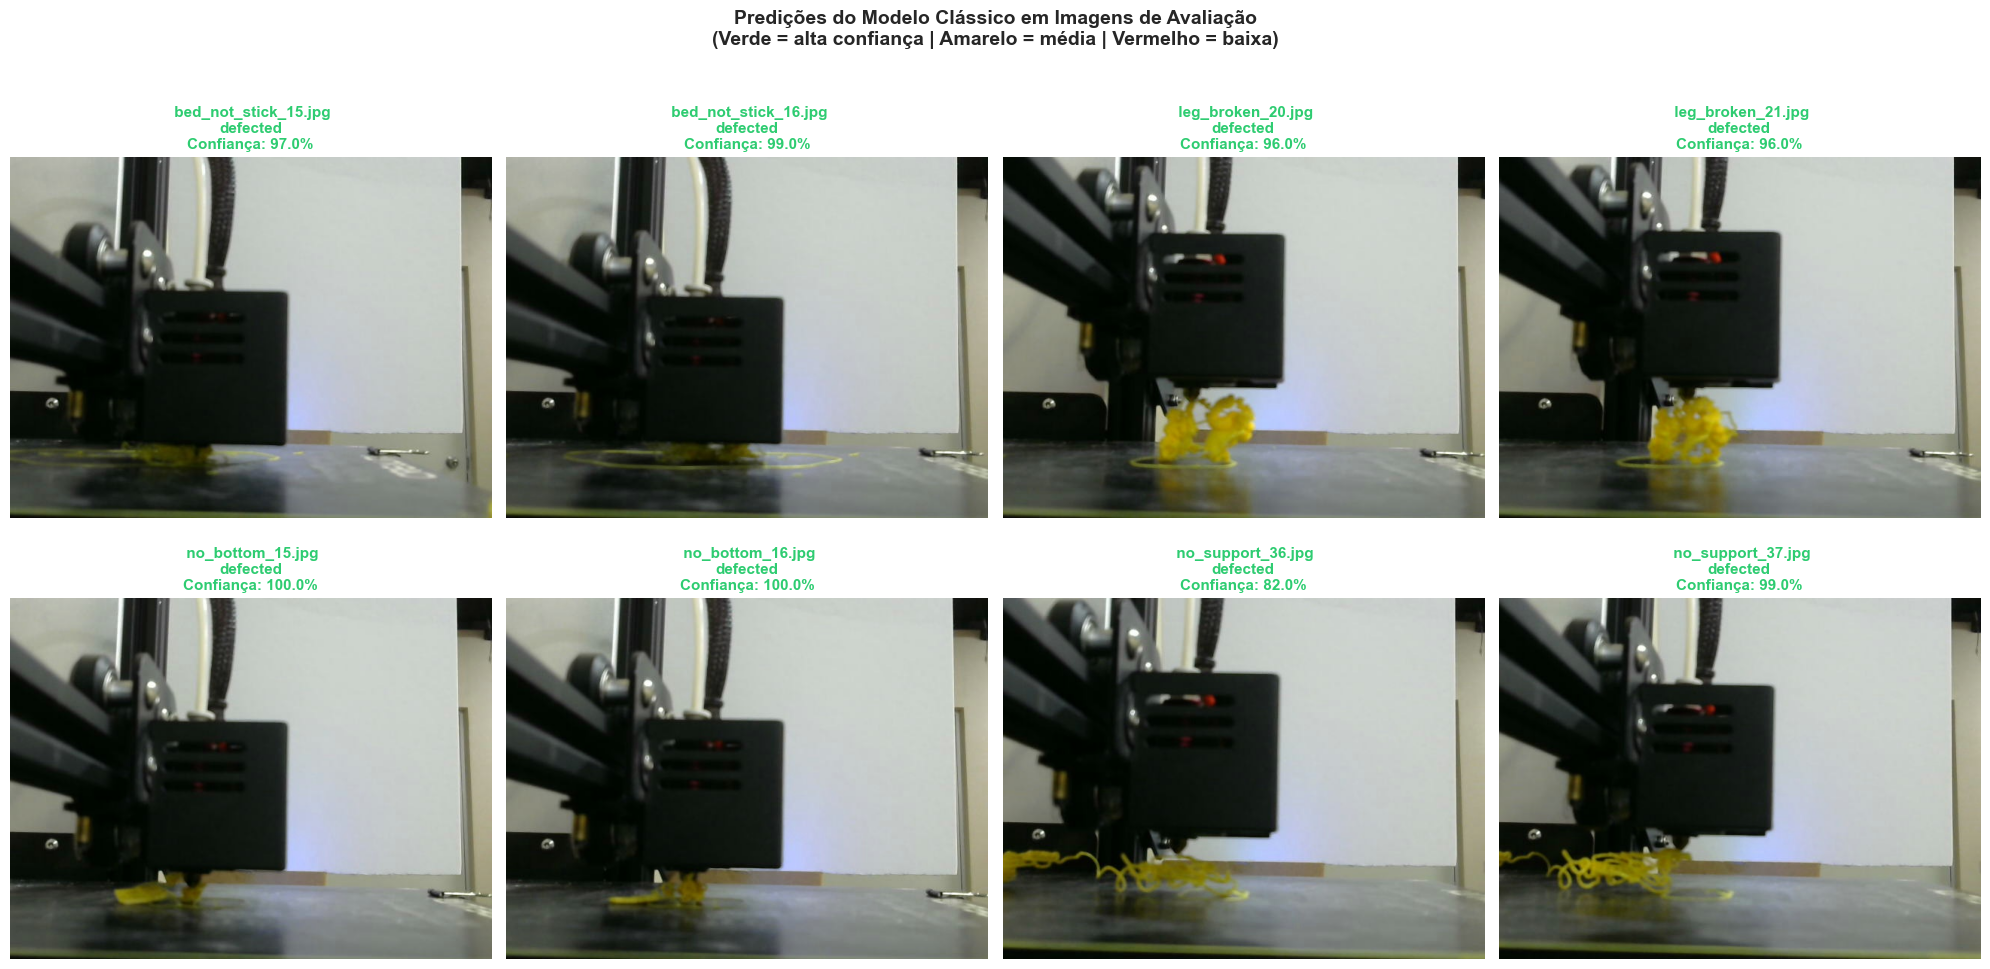


Resumo de todas as 8 imagens de avaliação:
   defected: 8 imagens (100.0%)
   Confiança média: 96.1%


In [28]:
# 🔮 Predição em Imagens de Avaliação
if X is not None:
    EVAL_PATH = Path("Avaliacao")

    if EVAL_PATH.exists():
        # Coleta todas as imagens de avaliação
        eval_images = list(EVAL_PATH.glob("**/*.jpg")) + list(EVAL_PATH.glob("**/*.png"))

        if eval_images:
            # Limita a quantidade para visualização
            max_show = min(len(eval_images), 12)
            eval_sample = eval_images[:max_show]

            # Calcula grid
            n_cols = min(4, max_show)
            n_rows = (max_show + n_cols - 1) // n_cols

            fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
            if n_rows == 1 and n_cols == 1:
                axes = np.array([[axes]])
            elif n_rows == 1:
                axes = axes[np.newaxis, :]
            elif n_cols == 1:
                axes = axes[:, np.newaxis]

            print("Predições do Random Forest em imagens de avaliação:\n")
            print(f"{'Imagem':<40} {'Predição':<20} {'Confiança':<15}")
            print("=" * 75)

            for idx, img_path in enumerate(eval_sample):
                row, col = divmod(idx, n_cols)

                # Extrai features e prediz
                feats = extract_features(img_path)

                if feats is not None:
                    prediction = clf_rf.predict([feats])[0]
                    proba = clf_rf.predict_proba([feats])[0]
                    confidence = proba.max()

                    # Mostra a imagem
                    img_bgr = read_image(img_path)
                    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
                    axes[row][col].imshow(img_rgb)

                    # Cor do título baseada na confiança
                    color = '#2ecc71' if confidence > 0.7 else '#f39c12' if confidence > 0.5 else '#e74c3c'
                    axes[row][col].set_title(f" {img_path.name}\n{prediction}\nConfiança: {confidence:.1%}",
                                            fontsize=11, fontweight='bold', color=color)
                    axes[row][col].axis('off')

                    # Nome do arquivo (relativo)
                    rel_name = img_path.name
                    print(f"{rel_name:<40} {prediction:<20} {confidence:<15.1%}")
                else:
                    axes[row][col].text(0.5, 0.5, "Erro ao\ncarregar", ha='center', va='center')
                    axes[row][col].axis('off')

            # Esconde subplots vazios
            for idx in range(max_show, n_rows * n_cols):
                row, col = divmod(idx, n_cols)
                axes[row][col].axis('off')

            plt.suptitle("Predições do Modelo Clássico em Imagens de Avaliação\n"
                        "(Verde = alta confiança | Amarelo = média | Vermelho = baixa)",
                        fontsize=14, fontweight='bold', y=1.02)
            plt.tight_layout()
            plt.show()

            # Resumo das predições
            all_preds = []
            all_confs = []
            for img_path in eval_images:
                feats = extract_features(img_path)
                if feats is not None:
                    pred = clf_rf.predict([feats])[0]
                    conf = clf_rf.predict_proba([feats])[0].max()
                    all_preds.append(pred)
                    all_confs.append(conf)

            if all_preds:
                print(f"\nResumo de todas as {len(all_preds)} imagens de avaliação:")
                pred_counts = pd.Series(all_preds).value_counts()
                for cls, count in pred_counts.items():
                    print(f"   {cls}: {count} imagens ({count/len(all_preds):.1%})")
                print(f"   Confiança média: {np.mean(all_confs):.1%}")
        else:
            print("Nenhuma imagem encontrada em", EVAL_PATH)
    else:
        print(f"Diretório de avaliação não encontrado: {EVAL_PATH}")
        print("   Certifique-se de que o diretório 'Datasets/3D-Printer-Avaliação' existe.")

---

## 4. Comparação: Clássico vs Azure Custom Vision

### Reflexão
1. **Precisão**: O modelo clássico provavelmenteteve performance inferior ao Azure. Por que? (Dica: representatividade das features manuais).
2. **Esforço**: No clássico, precisamos "inventar" as features (média de cor, borda). No Deep Learning (Azure), a rede aprende isso sozinha.
3. **Controle**: No clássico, sabemos exatamente o que está entrando (números de cor). No Azure, é uma "caixa preta".

### Quando usar Clássico?
- Hardware muito limitado (microcontrolador sem GPU).
- Pouquíssimos dados.
- Problema simples e bem definido (ex: cor vermelha = defeito).

---

## 5. Exportação e Importação de Modelos

### Por que exportar um modelo?

Treinar um modelo leva tempo — precisamos ler imagens, extrair features, ajustar parâmetros... Seria muito ineficiente repetir tudo isso toda vez que quisermos usar o modelo. A solução é **salvar (exportar)** o modelo treinado em um arquivo, e depois **carregar (importar)** quando precisarmos.

### O que é salvo no arquivo?

Quando exportamos um modelo com `joblib`, ele salva **tudo** que o modelo aprendeu:

| O que é salvo | Descrição |
|---|---|
| **Estrutura do modelo** | Tipo do algoritmo (Random Forest, SVM, etc.) |
| **Parâmetros aprendidos** | As "regras" que o modelo criou durante o treino |
| **Hiperparâmetros** | Configurações como número de árvores, kernel, etc. |
| **Classes conhecidas** | Quais categorias o modelo sabe classificar |

#### Para o **Random Forest**, isso inclui:
- Todas as **100 árvores de decisão** com suas regras (splits, thresholds)
- A importância de cada feature calculada

#### Para o **SVM**, isso inclui:
- Os **vetores de suporte** (pontos-chave que definem as fronteiras)
- Os **coeficientes** do hiperplano de separação
- O **scaler** (normalização) que precisamos salvar separadamente!

### Formatos comuns de exportação

| Formato | Biblioteca | Vantagem |
|---|---|---|
| `.joblib` | `joblib` | Rápido para arrays grandes (NumPy) |
| `.pkl` | `pickle` | Nativo do Python, mais genérico |
| `.onnx` | `onnxruntime` | Portável entre linguagens (C#, Java, etc.) |

Nesta aula usaremos **joblib** por ser o mais recomendado para scikit-learn.

In [29]:
import joblib
from pathlib import Path

# ── Pasta para salvar os modelos ──
MODELS_DIR = Path("modelos_exportados")
MODELS_DIR.mkdir(exist_ok=True)

# ── Exportar Random Forest ──
rf_path = MODELS_DIR / "random_forest_model.joblib"
joblib.dump(clf_rf, rf_path)
print(f"Random Forest salvo em: {rf_path}")
print(f"  - Tamanho do arquivo: {rf_path.stat().st_size / 1024:.1f} KB")
print(f"  - Numero de arvores: {clf_rf.n_estimators}")
print(f"  - Classes: {list(clf_rf.classes_)}")

# ── Exportar SVM ──
svm_path = MODELS_DIR / "svm_model.joblib"
joblib.dump(clf_svm, svm_path)
print(f"\nSVM salvo em: {svm_path}")
print(f"  - Tamanho do arquivo: {svm_path.stat().st_size / 1024:.1f} KB")
print(f"  - Kernel: {clf_svm.kernel}")
print(f"  - Vetores de suporte: {clf_svm.n_support_}")

# ── Exportar o Scaler (ESSENCIAL para o SVM!) ──
scaler_path = MODELS_DIR / "scaler.joblib"
joblib.dump(scaler, scaler_path)
print(f"\nScaler salvo em: {scaler_path}")
print(f"  - Tipo: {type(scaler).__name__}")
print(f"  - Media por feature: {[f'{m:.2f}' for m in scaler.mean_]}")
print(f"  - Desvio padrao por feature: {[f'{s:.2f}' for s in scaler.scale_]}")

print(f"\n{'='*50}")
print(f"Todos os modelos exportados na pasta: {MODELS_DIR}/")
print(f"Arquivos: {[f.name for f in MODELS_DIR.iterdir()]}")

Random Forest salvo em: modelos_exportados\random_forest_model.joblib
  - Tamanho do arquivo: 1182.0 KB
  - Numero de arvores: 100
  - Classes: [np.str_('defected'), np.str_('no_defected')]

SVM salvo em: modelos_exportados\svm_model.joblib
  - Tamanho do arquivo: 28.1 KB
  - Kernel: rbf
  - Vetores de suporte: [175 181]

Scaler salvo em: modelos_exportados\scaler.joblib
  - Tipo: StandardScaler
  - Media por feature: ['108.75', '117.81', '113.46', '81.34', '78.74', '78.84', '3.54']
  - Desvio padrao por feature: ['4.16', '3.31', '3.33', '3.06', '3.36', '3.50', '0.42']

Todos os modelos exportados na pasta: modelos_exportados/
Arquivos: ['random_forest_model.joblib', 'scaler.joblib', 'svm_model.joblib']


### O que acabou de acontecer?

Usámos `joblib.dump()` para serializar cada objeto Python e gravá-lo em disco.

**Serializar** significa transformar um objeto que está na memória RAM (temporário) em uma sequência de bytes que pode ser salva em arquivo (permanente).

> **Analogia simples:** Imagine que você montou um castelo de LEGO. Serializar é como tirar uma foto + lista de instruções de cada peça e onde ela vai. Quando quiser reconstruir, basta seguir as instruções (deserializar).

#### Por que salvamos o Scaler separadamente?

O **SVM** precisa que os dados estejam **normalizados** (na mesma escala) para funcionar bem. O `StandardScaler` guarda:
- A **média** de cada feature nos dados de treino
- O **desvio padrão** de cada feature nos dados de treino

Se não salvarmos o scaler, ao importar o SVM depois, não saberemos como normalizar as novas imagens da mesma forma que normalizámos as de treino — e as previsões ficariam erradas!

O **Random Forest** não precisa de normalização — ele funciona com os valores originais.

---

## 5.1. Importação e Uso dos Modelos Exportados

Agora vamos simular um cenário real: imagine que este é um **novo script** ou **novo notebook** e você quer usar o modelo sem retreinar. Basta carregar o arquivo `.joblib`!

In [ ]:
pip install ipywidgets

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# ── Seletor de Modelo ──
modelo_selector = widgets.Dropdown(
    options=[
        ('Random Forest', 'random_forest'),
        ('SVM (Support Vector Machine)', 'svm')
    ],
    value='random_forest',
    description='Modelo:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='350px')
)

info_box = widgets.Output()

def on_model_change(change):
    with info_box:
        clear_output()
        if change['new'] == 'random_forest':
            print("Random Forest selecionado!")
            print("- Nao precisa de normalizacao (scaler)")
            print("- Usa ensemble de 100 arvores de decisao")
            print("- Robusto a outliers e dados nao normalizados")
        else:
            print("SVM selecionado!")
            print("- Precisa de normalizacao (StandardScaler)")
            print("- Usa vetores de suporte para separar classes")
            print("- Melhor com dados bem normalizados")

modelo_selector.observe(on_model_change, names='value')

# Disparar evento inicial
on_model_change({'new': modelo_selector.value})

print("Selecione o modelo para usar nas predicoes:\n")
display(widgets.VBox([modelo_selector, info_box]))

Selecione o modelo para usar nas predicoes:



In [42]:
import joblib
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ── Definicoes (simulando um novo script) ──
MODELS_DIR = Path("modelos_exportados")
EVAL_PATH  = Path("Avaliacao")
feature_names = ['mean_B', 'mean_G', 'mean_R', 'std_B', 'std_G', 'std_R', 'edge_density']

# ── Funcao de leitura de imagem (suporte a caminhos Unicode) ──
def read_image(path):
    img = cv2.imread(str(path))
    if img is None:
        data = np.fromfile(str(path), dtype=np.uint8)
        img = cv2.imdecode(data, cv2.IMREAD_COLOR)
    return img

# ── Funcao de extracao de features (identica a original) ──
def extract_features(img_path):
    img = read_image(img_path)
    if img is None:
        return None
    mean_color = img.mean(axis=(0, 1))
    std_color  = img.std(axis=(0, 1))
    gray  = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    edge_density = np.sum(edges) / (edges.shape[0] * edges.shape[1])
    return np.concatenate([mean_color, std_color, [edge_density]])

# ── Carregar o modelo selecionado ──
modelo_escolhido = modelo_selector.value  # Lê do widget acima

if modelo_escolhido == 'random_forest':
    modelo = joblib.load(MODELS_DIR / "random_forest_model.joblib")
    use_scaler = False
    nome_modelo = "Random Forest"
    print(f"Modelo carregado: Random Forest")
    print(f"  - Tipo: {type(modelo).__name__}")
    print(f"  - Arvores: {modelo.n_estimators}")
    print(f"  - Classes: {list(modelo.classes_)}")
else:
    modelo = joblib.load(MODELS_DIR / "svm_model.joblib")
    scaler_importado = joblib.load(MODELS_DIR / "scaler.joblib")
    use_scaler = True
    nome_modelo = "SVM"
    print(f"Modelo carregado: SVM")
    print(f"  - Tipo: {type(modelo).__name__}")
    print(f"  - Kernel: {modelo.kernel}")
    print(f"  - Scaler carregado: {type(scaler_importado).__name__}")
    print(f"  - Media do scaler: {[f'{m:.2f}' for m in scaler_importado.mean_]}")

print(f"\n{'='*50}")
print(f"Modelo '{nome_modelo}' pronto para fazer predicoes!")

Modelo carregado: SVM
  - Tipo: SVC
  - Kernel: rbf
  - Scaler carregado: StandardScaler
  - Media do scaler: ['108.75', '117.81', '113.46', '81.34', '78.74', '78.84', '3.54']

Modelo 'SVM' pronto para fazer predicoes!


In [35]:
EVAL_PATH.exists()

True

Ambiente: Local
EVAL_PATH: Avaliacao
[WindowsPath('Avaliacao/bed_not_stick_15.jpg'), WindowsPath('Avaliacao/bed_not_stick_16.jpg'), WindowsPath('Avaliacao/leg_broken_20.jpg'), WindowsPath('Avaliacao/leg_broken_21.jpg'), WindowsPath('Avaliacao/no_bottom_15.jpg'), WindowsPath('Avaliacao/no_bottom_16.jpg'), WindowsPath('Avaliacao/no_support_36.jpg'), WindowsPath('Avaliacao/no_support_37.jpg')]


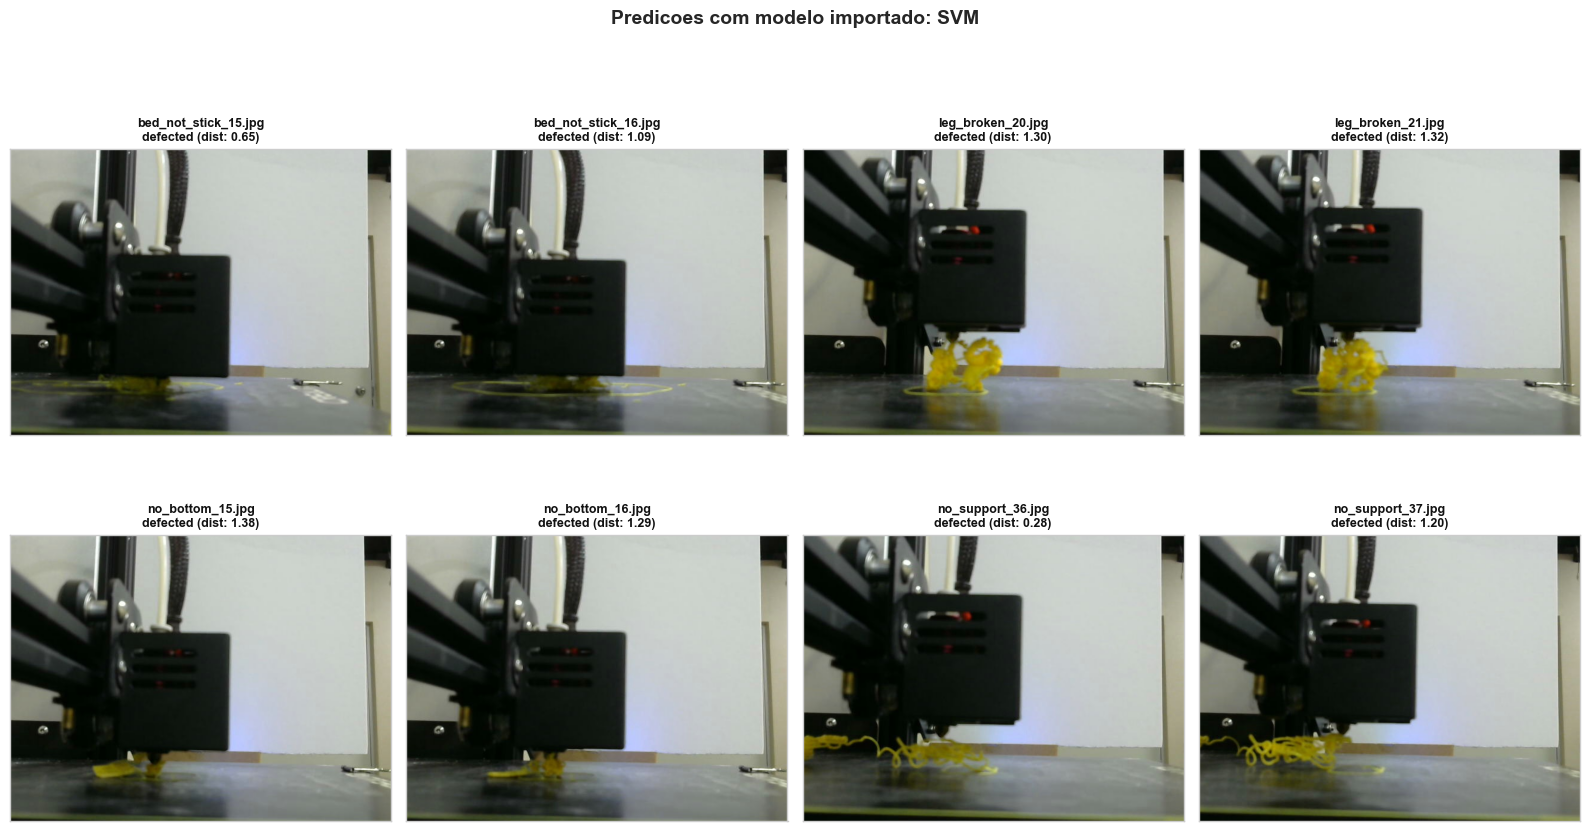


Resumo das predicoes (SVM importado):
  bed_not_stick_15.jpg           -> defected     (distancia: 0.65)
  bed_not_stick_16.jpg           -> defected     (distancia: 1.09)
  leg_broken_20.jpg              -> defected     (distancia: 1.30)
  leg_broken_21.jpg              -> defected     (distancia: 1.32)
  no_bottom_15.jpg               -> defected     (distancia: 1.38)
  no_bottom_16.jpg               -> defected     (distancia: 1.29)
  no_support_36.jpg              -> defected     (distancia: 0.28)
  no_support_37.jpg              -> defected     (distancia: 1.20)

Total: 0 defeituosas, 0 sem defeito, de 8 imagens


In [43]:
# ── Detecção de ambiente (Colab vs Local) ──
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    DRIVE_BASE = Path('/content/drive/MyDrive/Colab Notebooks/Visão Computacional/Azure - Custom Vision/')
    EVAL_PATH  = DRIVE_BASE / "3D-Printer-Avaliacao/defected" # Deixar umas amostras na raiz da pasta de avaliação
    print(f"Ambiente: Google Colab")
    print(f"EVAL_PATH: {EVAL_PATH}")
else:
    # Mantém o caminho local definido na célula anterior
    print(f"Ambiente: Local")
    print(f"EVAL_PATH: {EVAL_PATH}")

# ── Predicoes nas imagens de avaliacao com o modelo importado ──
eval_images = sorted([f for f in EVAL_PATH.iterdir()
                      if f.suffix.lower() in ('.jpg', '.jpeg', '.png', '.bmp')])

print(eval_images)

resultados = []

for img_path in eval_images:
    feats = extract_features(img_path)
    if feats is None:
        resultados.append((img_path.name, "ERRO", 0.0))
        continue

    feats_2d = feats.reshape(1, -1)

    if use_scaler:
        feats_2d = scaler_importado.transform(feats_2d)

    pred = modelo.predict(feats_2d)[0]

    # Confianca: RF tem predict_proba; SVM com probability=False usa decision_function
    if hasattr(modelo, 'predict_proba'):
        proba = modelo.predict_proba(feats_2d)[0]
        conf = proba.max() * 100
    elif hasattr(modelo, 'decision_function'):
        dec = modelo.decision_function(feats_2d)[0]
        conf = abs(dec)  # distancia ao hiperplano (nao e %)
    else:
        conf = 0.0

    resultados.append((img_path.name, pred, conf))

# ── Exibir resultados em grid visual ──
n_imgs = len(eval_images)
cols = min(4, n_imgs)
rows = (n_imgs + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4.5 * rows))
if rows == 1 and cols == 1:
    axes = np.array([axes])
axes = axes.flatten()

for i, (img_path, (nome, pred, conf)) in enumerate(zip(eval_images, resultados)):
    ax = axes[i]
    img = read_image(img_path)
    if img is not None:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img_rgb)
    ax.set_xticks([])
    ax.set_yticks([])

    if pred == "ERRO":
        cor = 'red'
        titulo = f"{nome}\nERRO na leitura"
    else:
        cor = '#2ecc71' if pred == 'def_free' else "#121212"
        if hasattr(modelo, 'predict_proba'):
            titulo = f"{nome}\n{pred} ({conf:.1f}%)"
        else:
            titulo = f"{nome}\n{pred} (dist: {conf:.2f})"

    ax.set_title(titulo, fontsize=9, fontweight='bold', color=cor)

# Esconder eixos vazios
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

fig.suptitle(f"Predicoes com modelo importado: {nome_modelo}",
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

# ── Resumo ──
print(f"\nResumo das predicoes ({nome_modelo} importado):")
print(f"{'='*50}")
for nome, pred, conf in resultados:
    if pred != "ERRO":
        if hasattr(modelo, 'predict_proba'):
            print(f"  {nome:30s} -> {pred:12s} (confianca: {conf:.1f}%)")
        else:
            print(f"  {nome:30s} -> {pred:12s} (distancia: {conf:.2f})")
    else:
        print(f"  {nome:30s} -> ERRO")

n_def = sum(1 for _, p, _ in resultados if p == 'defective')
n_free = sum(1 for _, p, _ in resultados if p == 'def_free')
print(f"\nTotal: {n_def} defeituosas, {n_free} sem defeito, de {len(resultados)} imagens")

### O que aconteceu nesta seção?

1. **Exportámos** os modelos com `joblib.dump()` — cada modelo virou um arquivo `.joblib`
2. **Importámos** o modelo selecionado com `joblib.load()` — reconstruímos o objeto na memória
3. **Fizemos predições** nas imagens de avaliação usando o modelo importado

#### Fluxo completo (o que acontece "por trás"):

```
EXPORTAR (treino)                          IMPORTAR (produção)
┌─────────────────┐                       ┌─────────────────┐
│  Treinar modelo  │                       │  joblib.load()  │
│  clf_rf.fit()    │──► joblib.dump() ──►  │  Recria objeto  │
│                  │    (salva arquivo)     │  na memória     │
└─────────────────┘                       └────────┬────────┘
                                                   │
                                          ┌────────▼────────┐
                                          │  modelo.predict()│
                                          │  Usa sem treinar │
                                          │  novamente!      │
                                          └─────────────────┘
```

#### Pontos importantes:
- O modelo importado produz **exatamente** os mesmos resultados que o original
- Não é necessário ter os dados de treino para fazer predições
- Para o SVM, **sempre** importe o `scaler` junto e aplique `scaler.transform()` antes de `predict()`
- Altere a seleção no dropdown acima e re-execute as 2 células seguintes para comparar os modelos!